In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def get_results(dir_model_a_directory, dir_model_b_directory):
        acc_rgb_text_location = os.path.join(dir_model_a_directory, "results.txt")
        acc_depth_text_location = os.path.join(dir_model_b_directory, "results.txt")

        # Accuracy values from the text file
        acc_rgb_values_text = open(acc_rgb_text_location).read()
        acc_depth_values_text = open(acc_depth_text_location).read()

        class_metric_search = "ious"
        class_metric_start = "acc:"

        pred_metric_search = "mious"
        pred_metric_start = "miou:"

        float_regex = r"[-+]?\d*\.\d+|\d+"

        # Parse accuracy values from the text file
        class_iou_rgb_values = []
        mean_pred_iou_rgb_values = []
        pred_iou_rgb_values = []
        for i, line in enumerate(acc_rgb_values_text.split("\n")):
            if line.startswith(class_metric_start):
                mean_prediction_iou = line.split(pred_metric_start)[1]
                mean_pred_iou_rgb_values.append(float(mean_prediction_iou.strip()))
                # Get iou values for each class from the final epoch
                line = line.split(class_metric_search)[1].split("],")[0]
                values = [float(x) for x in re.findall(float_regex, line)]
                class_iou_rgb_values = values
                
            if line.startswith(pred_metric_start) and pred_metric_search in line:
                line = line.split(pred_metric_search)[1].split("],")[0]
                pred_iou_rgb_values.append([float(x) for x in re.findall(float_regex, line)])

        class_iou_depth_values = []
        mean_pred_iou_depth_values = []
        pred_iou_depth_values = []
        for i, line in enumerate(acc_depth_values_text.split("\n")):
            if line.startswith(class_metric_start):
                mean_prediction_iou = line.split(pred_metric_start)[1]
                mean_pred_iou_depth_values.append(float(mean_prediction_iou.strip()))
                # Get iou values for each class from the final epoch
                line = line.split(class_metric_search)[1].split("],")[0]
                values = [float(x) for x in re.findall(float_regex, line)]
                class_iou_depth_values = values

            if line.startswith(pred_metric_start) and pred_metric_search in line:
                line = line.split(pred_metric_search)[1].split("],")[0]
                pred_iou_depth_values.append([float(x) for x in re.findall(float_regex, line)])

        return class_iou_rgb_values, mean_pred_iou_rgb_values, pred_iou_rgb_values, class_iou_depth_values, mean_pred_iou_depth_values, pred_iou_depth_values

In [2]:
import matplotlib.pyplot as plt
import matplotlib

# Implementation from: https://stackoverflow.com/questions/18517722/weighted-moving-average-in-python
def weighted_moving_average(x,y,step_size=0.05,width=1):
    bin_centers  = np.arange(np.min(x),np.max(x)-0.5*step_size,step_size)+0.5*step_size
    bin_avg = np.zeros(len(bin_centers))

    # Weighting with a Gaussian function
    def gaussian(x,amp=1,mean=0,sigma=1):
        return amp*np.exp(-(x-mean)**2/(2*sigma**2))

    for index in range(0,len(bin_centers)):
        bin_center = bin_centers[index]
        weights = gaussian(x,mean=bin_center,sigma=width)
        bin_avg[index] = np.average(y,weights=weights)

    return (bin_centers,bin_avg)


def plot_saturation_results(pred_iou_rgb_values_1, pred_iou_rgb_values_2, pred_iou_depth_values_1, pred_iou_depth_values_2, title="", train_split=0.42857):
    # Plot the results
    num_data_points = max(len(pred_iou_rgb_values_1), len(pred_iou_rgb_values_2), len(pred_iou_depth_values_1), len(pred_iou_depth_values_2))
    font = {'family': 'sans-serif',
        'size'   : 12}

    matplotlib.rc('font', **font)

    # Set distinct colors for each plot
    plt.figure(figsize=(20, 10))
    plt.plot(range(len(pred_iou_rgb_values_1)), pred_iou_rgb_values_1, 'o', label='RGB', color='#FF69B4')
    plt.plot(range(len(pred_iou_rgb_values_2)), pred_iou_rgb_values_2, 'o', color='#FF69B4')
    plt.plot(range(len(pred_iou_depth_values_1)), pred_iou_depth_values_1, 'o', label='RGB + Depth', color='green')
    plt.plot(range(len(pred_iou_depth_values_2)), pred_iou_depth_values_2, 'o', color='green')

    bins_1, avg_1 = weighted_moving_average(range(len(pred_iou_rgb_values_1)), pred_iou_rgb_values_1, step_size=0.1, width=50)
    bins_2, avg_2 = weighted_moving_average(range(len(pred_iou_rgb_values_2)), pred_iou_rgb_values_2, step_size=0.1, width=50)

    bins = (bins_1 + bins_2) / 2
    avg = (avg_1 + avg_2) / 2

    plt.plot(bins, avg, label='Weighted moving average RGB', color='red')

    bins_1, avg_1 = weighted_moving_average(range(len(pred_iou_depth_values_1)), pred_iou_depth_values_1, step_size=0.1, width=50)
    bins_2, avg_2 = weighted_moving_average(range(len(pred_iou_depth_values_2)), pred_iou_depth_values_2, step_size=0.1, width=50)

    bins = (bins_1 + bins_2) / 2
    avg = (avg_1 + avg_2) / 2

    plt.plot(bins, avg, label='Weighted moving average RGB + Depth', color='blue')

    plt.title(title + ' IOU per saturation level')
    # Customize x axis ticks SATURATION
    tick_values = np.arange(0, num_data_points + (int)(num_data_points / 8), num_data_points / 7)
    tick_labels = np.arange(-75, 101, 25)
    plt.xticks(tick_values, tick_labels)
    plt.xlabel('Saturation')
    plt.ylabel('IOU')
    # plt.axvline(x=train_split * max_values, color='r', linestyle='--', label='Train split')
    plt.fill_between([0, train_split * num_data_points], 0, 100, color='red', alpha=0.1, label='data in training set')
    plt.fill_between([train_split * num_data_points, num_data_points], 0, 100, color='blue', alpha=0.1, label='data outside training set')
    plt.legend()
    plt.legend()
    plt.show()

def plot_saturation_results_2(pred_iou_rgb_values, pred_iou_rgb_depth_values, pred_iou_depth_values=[],  title="", train_split=0.4, min_saturation=-75, max_saturation=101, step=25):
    num_data_points = max(len(pred_iou_rgb_values), len(pred_iou_rgb_depth_values))
    font = {'family': 'sans-serif',
        'size'   : 12}

    matplotlib.rc('font', **font)

    # Set distinct colors for each plot
    color_data_rgb = '#FF69B4'
    color_data_rgb_depth = 'green'
    color_data_depth = '#346BEB'

    color_trend_rgb = 'red'
    color_trend_rgb_depth = 'blue'
    color_trend_depth = 'black'

    plt.figure(figsize=(20, 10))
    plt.plot(range(len(pred_iou_rgb_values)), pred_iou_rgb_values, marker='o', linestyle='None', label='RGB', color=color_data_rgb)
    plt.plot(range(len(pred_iou_rgb_depth_values)), pred_iou_rgb_depth_values, marker='^', linestyle='None', label='RGB + Depth', color=color_data_rgb_depth)
    if len(pred_iou_depth_values) > 0:
        plt.plot(range(len(pred_iou_depth_values)), pred_iou_depth_values, marker='s', linestyle='None', label='Depth', color=color_data_depth)

    bins, avg = weighted_moving_average(range(len(pred_iou_rgb_values)), pred_iou_rgb_values, step_size=0.1, width=50)
    plt.plot(bins, avg, label='Weighted moving average RGB', color=color_trend_rgb)

    bins, avg = weighted_moving_average(range(len(pred_iou_rgb_depth_values)), pred_iou_rgb_depth_values, step_size=0.1, width=50)
    plt.plot(bins, avg, label='Weighted moving average RGB + Depth', color=color_trend_rgb_depth)

    if len(pred_iou_depth_values) > 0:
        bins, avg = weighted_moving_average(range(len(pred_iou_depth_values)), pred_iou_depth_values, step_size=0.1, width=50)
        plt.plot(bins, avg, label='Weighted moving average Depth', color=color_trend_depth)


    
    plt.title(title + ' IOU per saturation level')
    # Customize x axis ticks SATURATION
    steps = (int)((max_saturation - min_saturation) / step)
    # tick_values = np.arange(0, num_data_points + (int)(num_data_points / steps), num_data_points / (steps-1))
    
    tick_labels = np.arange(min_saturation, max_saturation, step)
    tick_values = np.linspace(0, num_data_points, len(tick_labels))
    # tick_labels = np.logspace(np.log10(min_saturation), np.log10(max_saturation), steps)
    # Round the labels
    tick_labels = [round(label, 2) for label in tick_labels]
    plt.xticks(tick_values, tick_labels)
    plt.xlabel('Saturation')
    plt.ylabel('IOU')
    min_value = min(min(pred_iou_rgb_values), min(pred_iou_rgb_depth_values)) - 1.0
    max_value = max(max(pred_iou_rgb_values), max(pred_iou_rgb_depth_values)) + 1.0
    if len(pred_iou_depth_values) > 0:
        min_value = min(min_value, min(pred_iou_depth_values))
        max_value = max(max_value, max(pred_iou_depth_values))
    if train_split is not None:
        if isinstance(train_split, tuple):
            plt.fill_between([0, train_split[0] * num_data_points], min_value, max_value, color='red', alpha=0.1, label='data in training set')
            plt.fill_between([train_split[0] * num_data_points, train_split[1] * num_data_points], min_value, max_value, color='blue', alpha=0.1, label='data outside training set')
            plt.fill_between([train_split[1] * num_data_points, num_data_points], min_value, max_value, color='red', alpha=0.1)
        else:
            plt.fill_between([0, train_split * num_data_points], min_value, max_value, color='blue', alpha=0.1, label='data in training set')
            plt.fill_between([train_split * num_data_points, num_data_points], min_value, max_value, color='red', alpha=0.1, label='data outside training set')
    plt.legend()
    plt.legend()
    plt.show()


def plot_experiment_results(data=[], title="Plot", axvlines=[], bin_size=50, xlabel="Saturation", ylabel="IOU", x_labels=[]):
    if len(data) == 0:
        return

    font = {'family': 'sans-serif',
        'size'   : 12}
    
    matplotlib.rc('font', **font)
    plt.figure(figsize=(20, 10))

    markers = ['o', '^', 's', 'd', 'p', 'h', 'v', '<', '>', 'D', 'P', 'H', 'X', '*', '+', 'x', '|', '_']

    min_data_value = 0.0
    max_data_value = 0.0
    num_data_points = len(data[0]['data_points'])

    for i, data_object in enumerate(data):
        assert 'data_points' in data_object, "data_points key is missing in data object"
        assert 'label' in data_object, "label key is missing in data object"
        assert 'color' in data_object, "color key is missing in data object"
        data_points = data_object['data_points']
        label = data_object['label']
        color = data_object['color']

        min_data_value = min(min_data_value, min(data_points)) if i > 0 else min(data_points) - 1.0
        max_data_value = max(max_data_value, max(data_points)) if i > 0 else max(data_points) + 1.0
        num_data_points = max(num_data_points, len(data_points))

        plt.plot(range(len(data_points)), data_points, marker=markers[i], linestyle='None', label=label, color=color)

        bins, avg = weighted_moving_average(range(len(data_points)), data_points, step_size=0.1, width=bin_size)
        plt.plot(bins, avg, label='Weighted moving average ' + label, color=color)

    plt.title(title)
    # Customize x axis ticks
    tick_labels = x_labels
    tick_values = np.linspace(0, num_data_points, len(tick_labels))
    plt.xticks(tick_values, tick_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add vertical sections
    previous_pos = 0.0
    current_pos = 0.0
    for axvline_data_object in axvlines:
        assert 'x' in axvline_data_object, "x key is missing in axvline_data_object"
        assert 'color' in axvline_data_object, "color key is missing in axvline_data_object"
        assert 'label' in axvline_data_object, "label key is missing in axvline_data_object"
        x = axvline_data_object['x']
        color = axvline_data_object['color']
        label = axvline_data_object['label']

        current_pos += (int)(x * num_data_points)
        print("current_pos: ", current_pos, " previous_pos: ", previous_pos)

        plt.fill_between([previous_pos, current_pos], min_data_value, max_data_value, color=color, alpha=0.1, label=label)

        previous_pos = current_pos

    plt.legend()
    plt.show()


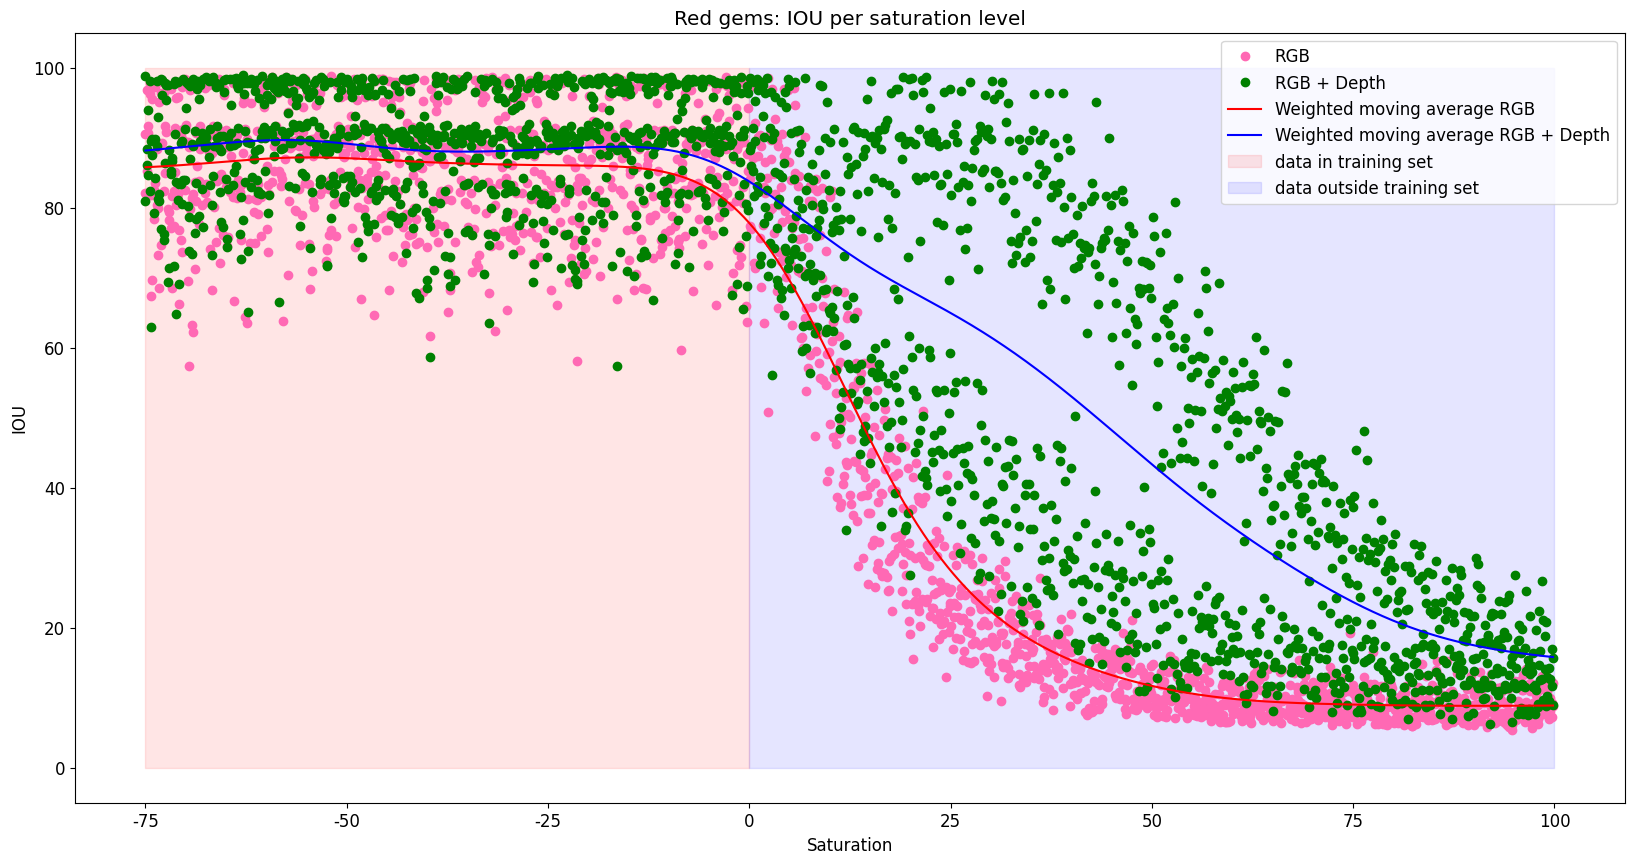

In [3]:
location_red_saturation_gems_b = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_DFormer-Tiny\run_20240414-005207"
location_red_saturation_gems_a = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_DFormer-Tiny\run_20240414-023738"
location_red_saturation_gems_2_b = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_2_DFormer-Tiny\run_20240415-013150"
location_red_saturation_gems_2_a = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_2_DFormer-Tiny\run_20240415-025311"

_, _, pred_iou_rgb_values_1, _, _, pred_iou_depth_values_1 = get_results(location_red_saturation_gems_a, location_red_saturation_gems_b)
_, _, pred_iou_rgb_values_2, _, _, pred_iou_depth_values_2 = get_results(location_red_saturation_gems_2_a, location_red_saturation_gems_2_b)
pred_iou_depth_values_1 = pred_iou_depth_values_1[-1]
pred_iou_depth_values_2 = pred_iou_depth_values_2[-1]
pred_iou_rgb_values_1 = pred_iou_rgb_values_1[-1]
pred_iou_rgb_values_2 = pred_iou_rgb_values_2[-1]

plot_saturation_results(pred_iou_rgb_values_1, pred_iou_rgb_values_2, pred_iou_depth_values_1, pred_iou_depth_values_2, title="Red gems:")

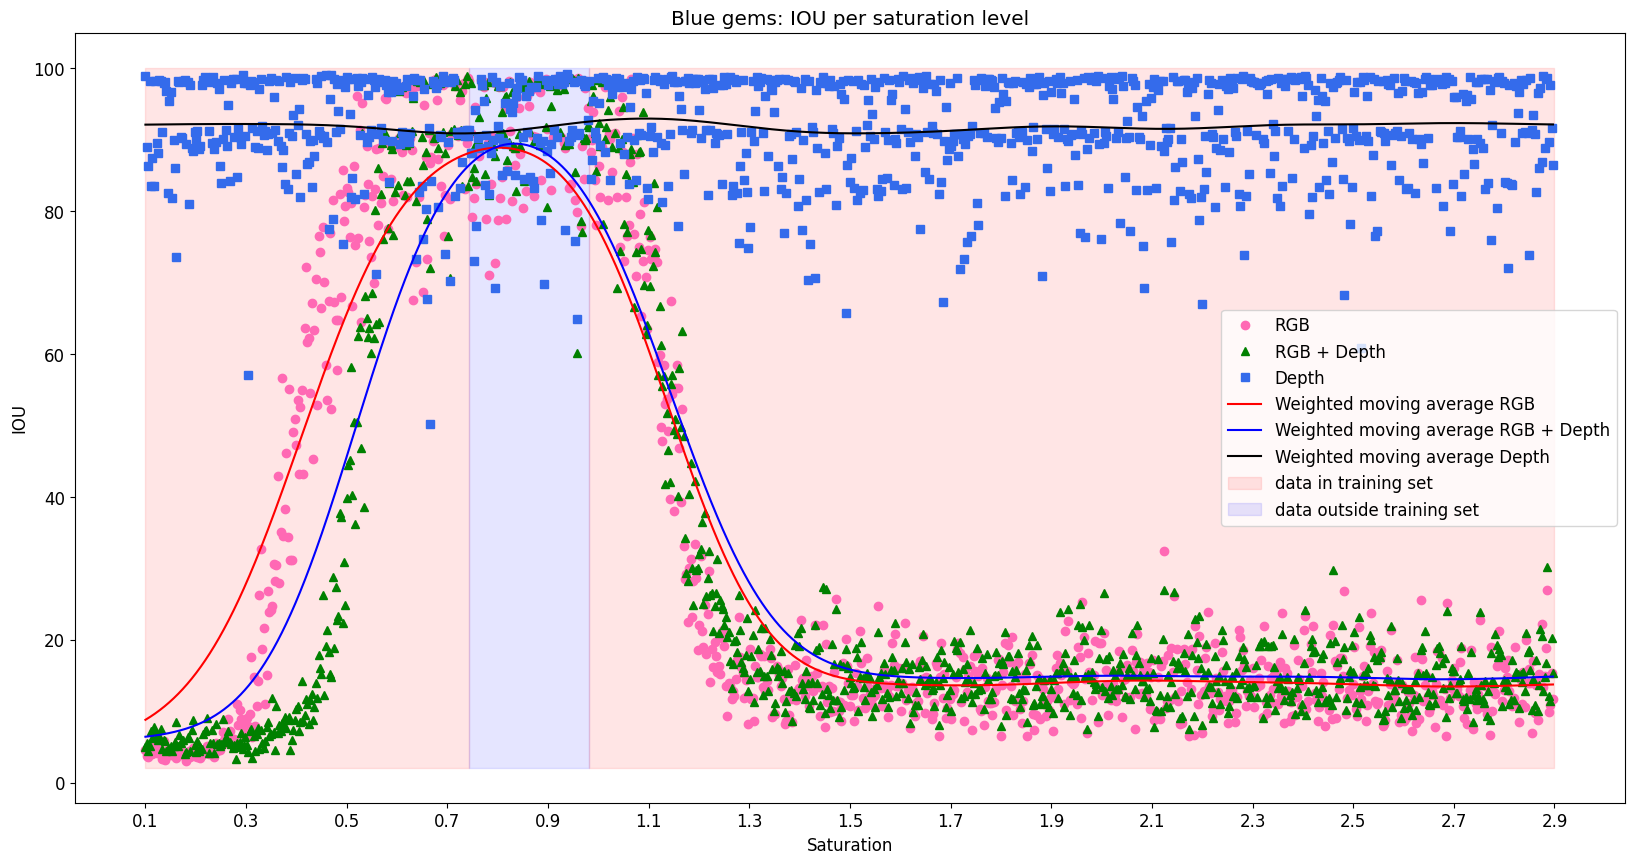

In [4]:
# location_blue_saturation_gems_b = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_DFormer-Tiny\run_20240414-130802"
# location_blue_saturation_gems_a = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_DFormer-Tiny\run_20240414-143827"
# location_blue_saturation_gems_b_2 = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_2_DFormer-Tiny\run_20240415-104257"
# location_blue_saturation_gems_a_2 = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_2_DFormer-Tiny\run_20240415-121110"

location_blue_saturation_gems_b_2 = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_DFormer-Tiny\run_20240417-225005"
location_blue_saturation_gems_a_2 = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_DFormer-Tiny\run_20240418-000249"
location_depth_saturation_gems = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_DFormer-Tiny\run_20240418-011103"


# _, _, pred_iou_rgb_values_1, _, _, pred_iou_depth_values_1 = get_results(location_blue_saturation_gems_a, location_blue_saturation_gems_b)
_, _, pred_iou_rgb_values_2, _, _, pred_iou_depth_values_2 = get_results(location_blue_saturation_gems_a_2, location_blue_saturation_gems_b_2)
pred_iou_rgb_values_1 = pred_iou_rgb_values_2
pred_iou_depth_values_1 = pred_iou_depth_values_2
_, _, pred_iou_depth_values , _, _, _= get_results(location_depth_saturation_gems, location_depth_saturation_gems)
pred_iou_depth_values_1 = pred_iou_depth_values_1[-1]
pred_iou_depth_values_2 = pred_iou_depth_values_2[-1]
pred_iou_rgb_values_1 = pred_iou_rgb_values_1[-1]
pred_iou_rgb_values_2 = pred_iou_rgb_values_2[-1]

pred_iou_rgb_values = (np.array(pred_iou_rgb_values_1) + np.array(pred_iou_rgb_values_2)) / 2.0
pred_iou_rgb_depth_values = (np.array(pred_iou_depth_values_1) + np.array(pred_iou_depth_values_2)) / 2.0
pred_iou_depth_values = pred_iou_depth_values[-1]

plot_saturation_results_2(
    pred_iou_rgb_values, 
    pred_iou_rgb_depth_values, 
    pred_iou_depth_values, 
    title="Blue gems:",
    train_split=(0.23, 0.315), 
    min_saturation=0.1, 
    max_saturation=3.0, 
    step=0.2
)

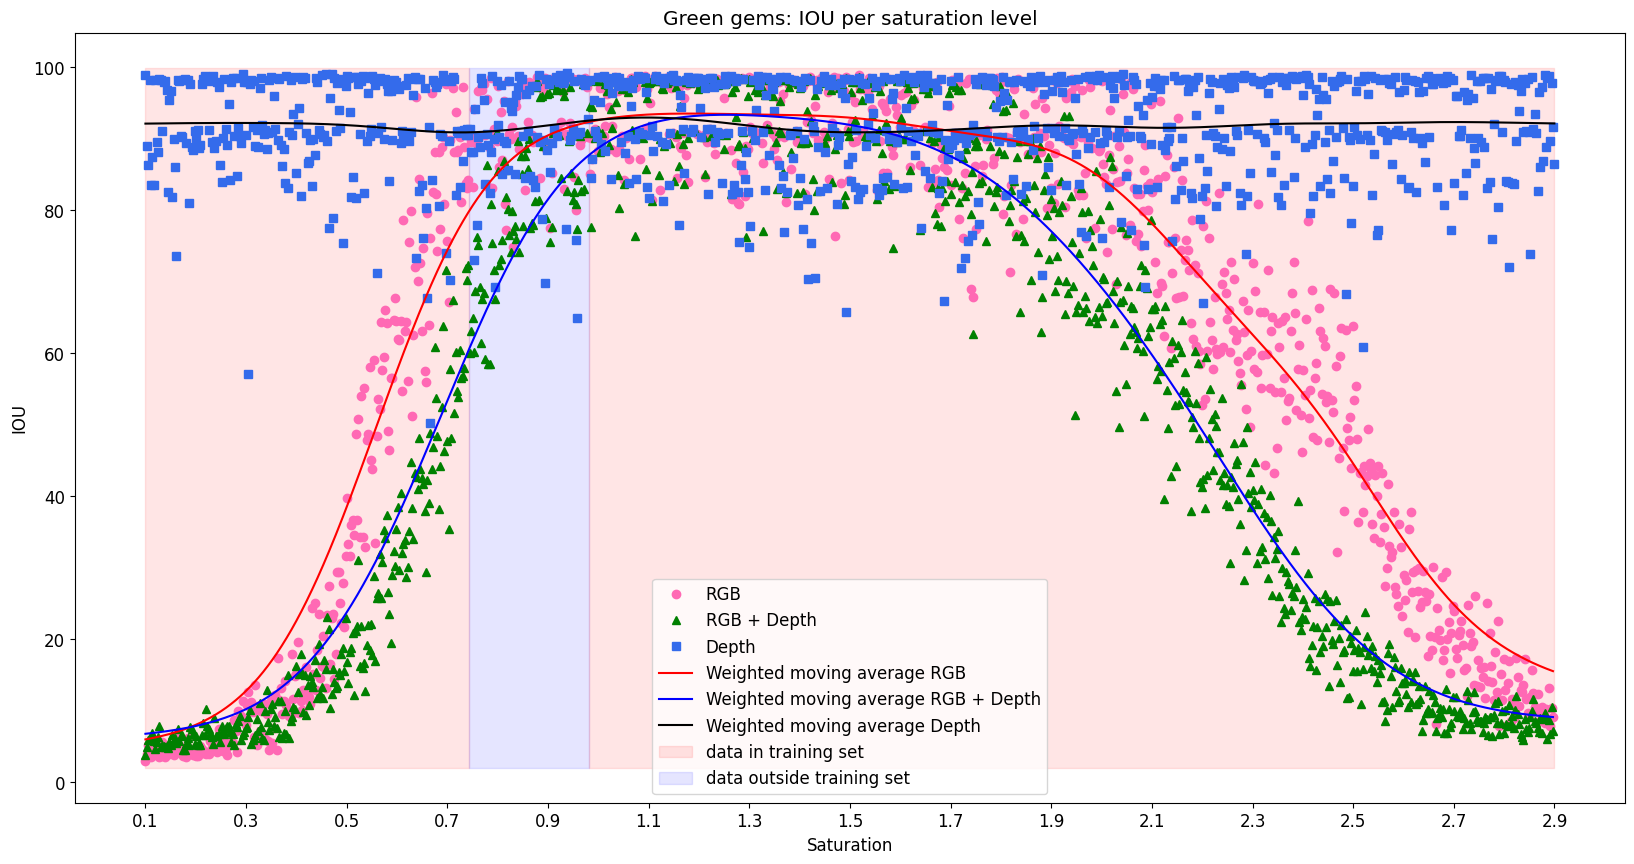

In [5]:
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240421-013903
location_green_saturation_gems_b = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240421-013903"
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240421-024957
location_green_saturation_gems_a = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240421-024957"

location_depth_saturation_gems = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_DFormer-Tiny\run_20240418-011103"


# _, _, pred_iou_rgb_values_1, _, _, pred_iou_depth_values_1 = get_results(location_blue_saturation_gems_a, location_blue_saturation_gems_b)
_, _, pred_iou_rgb_values_2, _, _, pred_iou_depth_values_2 = get_results(location_green_saturation_gems_a, location_green_saturation_gems_b)
pred_iou_rgb_values_1 = pred_iou_rgb_values_2
pred_iou_depth_values_1 = pred_iou_depth_values_2
_, _, pred_iou_depth_values , _, _, _= get_results(location_depth_saturation_gems, location_depth_saturation_gems)
pred_iou_depth_values_1 = pred_iou_depth_values_1[-1]
pred_iou_depth_values_2 = pred_iou_depth_values_2[-1]
pred_iou_rgb_values_1 = pred_iou_rgb_values_1[-1]
pred_iou_rgb_values_2 = pred_iou_rgb_values_2[-1]

pred_iou_rgb_values = (np.array(pred_iou_rgb_values_1) + np.array(pred_iou_rgb_values_2)) / 2.0
pred_iou_rgb_depth_values = (np.array(pred_iou_depth_values_1) + np.array(pred_iou_depth_values_2)) / 2.0
pred_iou_depth_values = pred_iou_depth_values[-1]

plot_saturation_results_2(
    pred_iou_rgb_values, 
    pred_iou_rgb_depth_values, 
    pred_iou_depth_values, 
    title="Green gems:",
    train_split=(0.23, 0.315), 
    min_saturation=0.1, 
    max_saturation=3.0, 
    step=0.2
)

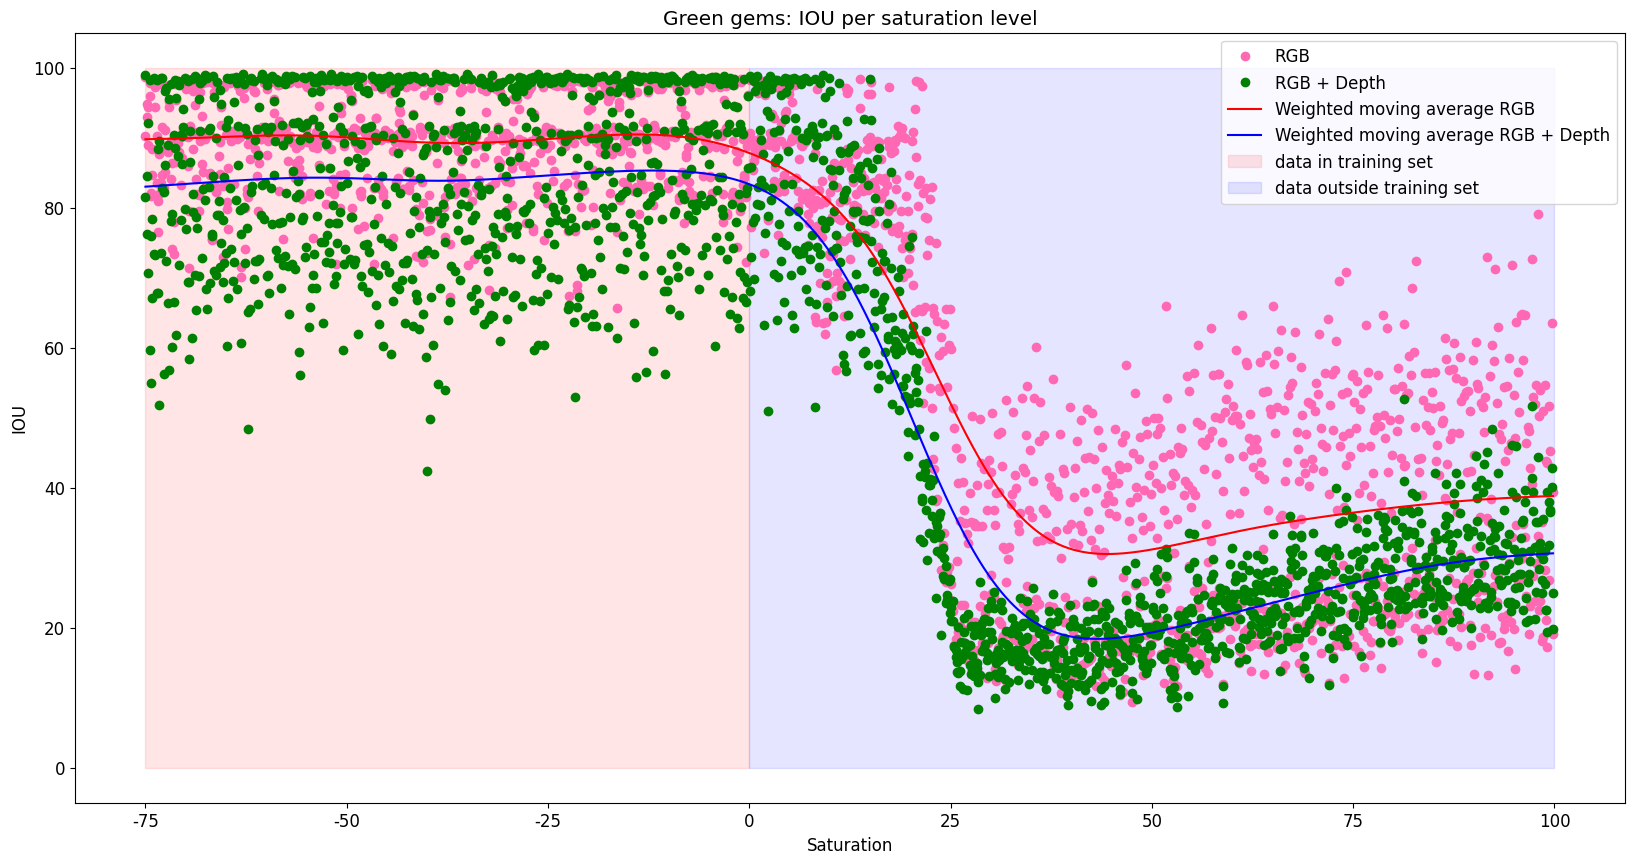

In [6]:
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240413-174237
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240413-193730
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-165950
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-184018

# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-194606
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-201641

location_green_saturation_gems_b = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240413-174237"
location_green_saturation_gems_a = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_DFormer-Tiny\run_20240413-193730"
location_green_saturation_gems_b_2 = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-165950"
location_green_saturation_gems_a_2 = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-184018"
# location_green_saturation_gems_b_2 = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-194606"
# location_green_saturation_gems_a_2 = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_2_DFormer-Tiny\run_20240414-201641"

_, _, pred_iou_rgb_values_1, _, _, pred_iou_depth_values_1 = get_results(location_green_saturation_gems_a, location_green_saturation_gems_b)
_, _, pred_iou_rgb_values_2, _, _, pred_iou_depth_values_2 = get_results(location_green_saturation_gems_a_2, location_green_saturation_gems_b_2)
pred_iou_depth_values_1 = pred_iou_depth_values_1[-1]
pred_iou_depth_values_2 = pred_iou_depth_values_2[-1]
pred_iou_rgb_values_1 = pred_iou_rgb_values_1[-1]
pred_iou_rgb_values_2 = pred_iou_rgb_values_2[-1]


plot_saturation_results(pred_iou_rgb_values_1, pred_iou_rgb_values_2, pred_iou_depth_values_1, pred_iou_depth_values_2, title="Green gems:")

In [8]:
location_sunrgbd_rgbd = r"..\checkpoints\SUNRGBD_DFormer-Tiny\run_20240416-180209_RGBD"
location_sunrgbd_rgb = r"..\checkpoints\SUNRGBD_DFormer-Tiny\run_20240416-224357_RGB"
# code\DFormer\checkpoints\SUNRGBD_DFormer-Tiny\run_20240417-104057
location_sunrgbd_depth = r"..\checkpoints\SUNRGBD_DFormer-Tiny\run_20240417-104057_Depth"

_, _, pred_iou_rgb_values, _, _, pred_iou_rgb_depth_values = get_results(location_sunrgbd_rgb, location_sunrgbd_rgbd)
_, _, pred_iou_depth_values, _, _, _ = get_results(location_sunrgbd_depth, location_sunrgbd_depth)
pred_iou_rgb_values_1 = pred_iou_rgb_values[3]
pred_iou_rgb_values_2 = pred_iou_rgb_values[1]
print(pred_iou_rgb_values_1[0], pred_iou_rgb_values_2[0]) #7.71 8.39
pred_iou_rgb_depth_values_1 = pred_iou_rgb_depth_values[2]
pred_iou_rgb_depth_values_2 = pred_iou_rgb_depth_values[1]
pred_iou_depth_values = pred_iou_depth_values[-1]

# pred_iou_rgb_values = np.array(pred_iou_rgb_values_2) - np.array(pred_iou_rgb_values_1)
# pred_iou_rgb_depth_values = np.array(pred_iou_rgb_depth_values_2) - np.array(pred_iou_rgb_depth_values_1)
# pred_iou_depth_values = np.array(pred_iou_depth_values)

pred_iou_rgb_depth_values = pred_iou_rgb_depth_values_1
pred_iou_rgb_values = pred_iou_rgb_values_1

# pred_iou_rgb_depth_values = np.zeros_like(pred_iou_rgb_values)
pred_iou_depth_values = np.zeros_like(pred_iou_rgb_values)

7.71 8.39


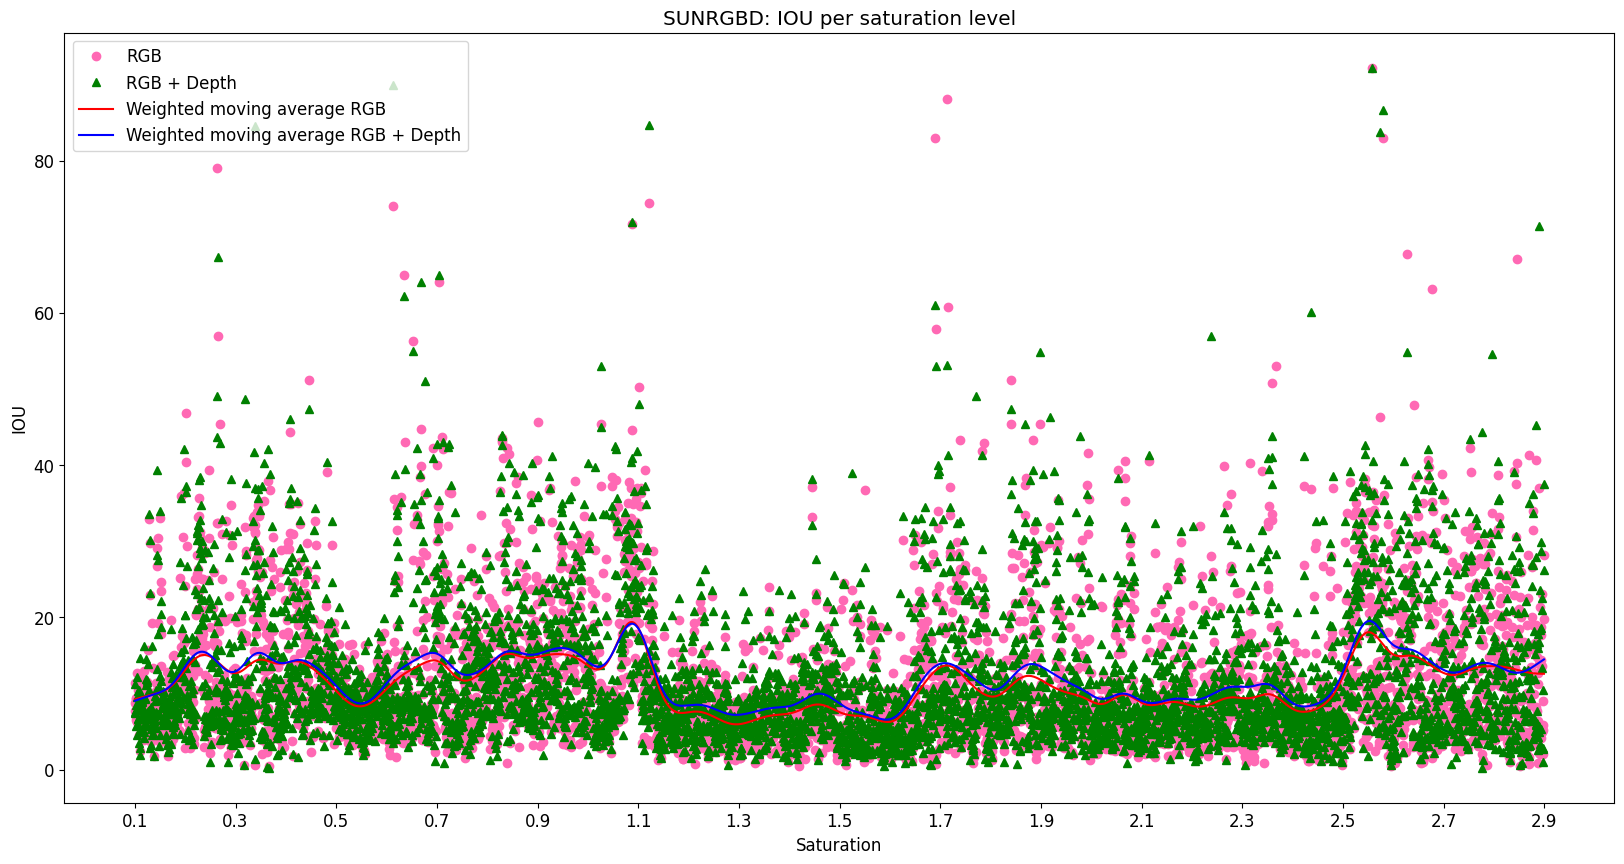

In [38]:
plot_saturation_results_2(
    pred_iou_rgb_values, 
    pred_iou_rgb_depth_values, 
    title="SUNRGBD:", 
    train_split=None, #(0.24137 - 0.1, 0.24137 + 0.1),
    min_saturation=0.1, 
    max_saturation=3.1, 
    step=0.2
)

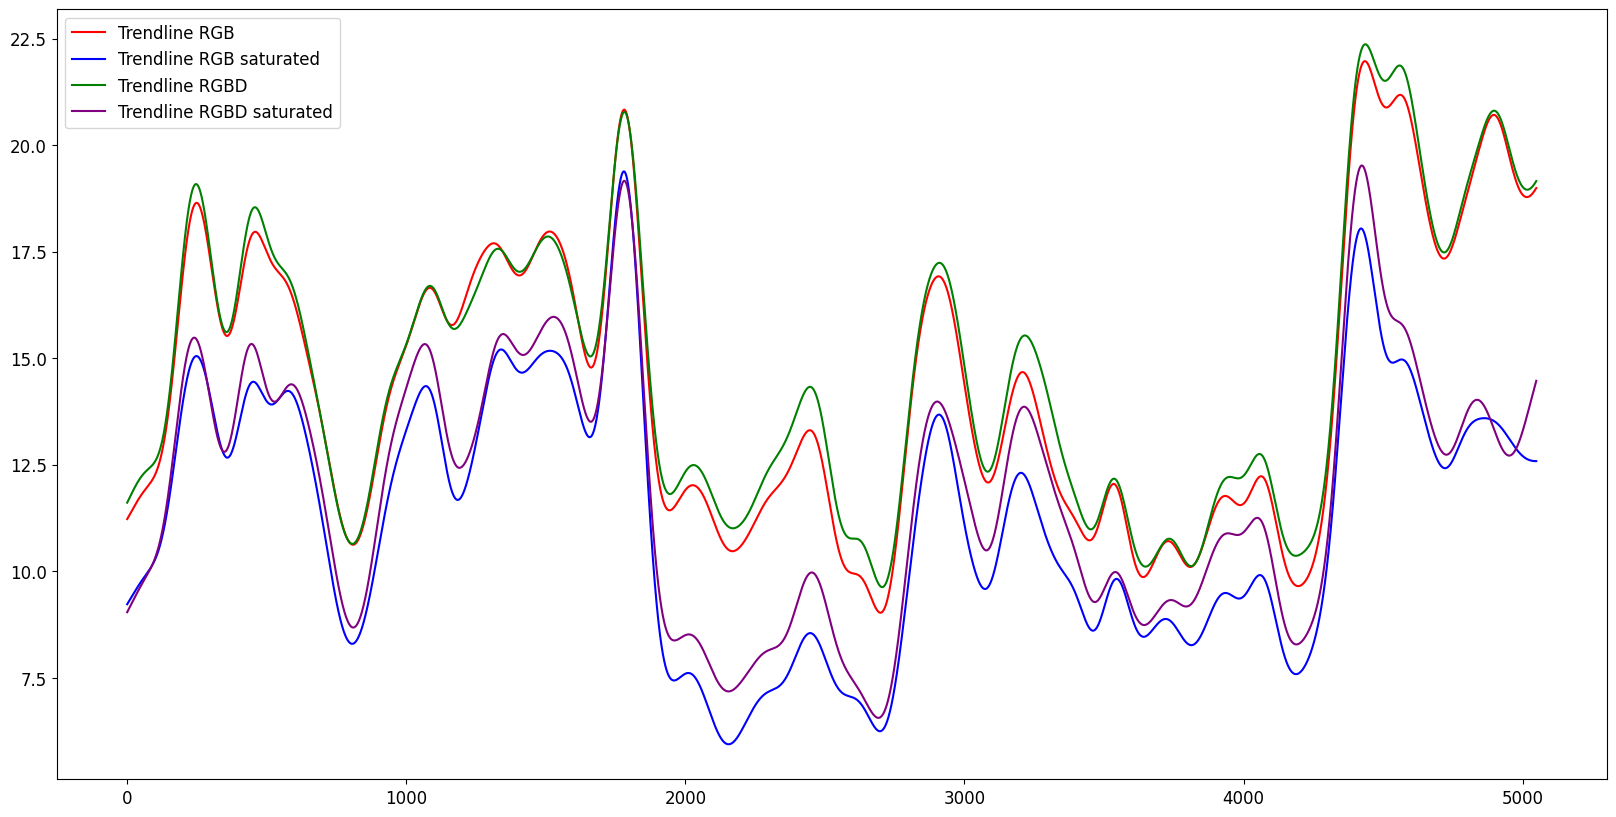

In [39]:
def plot_saturation_results(original_rgb, saturated_rgb, original_rgbd, saturated_rgbd):
    plt.figure(figsize=(20, 10))
    bins, avg = weighted_moving_average(range(len(original_rgb)), original_rgb, step_size=0.1, width=50)
    plt.plot(bins, avg, label='Trendline RGB', color='red')
    bins, avg = weighted_moving_average(range(len(saturated_rgb)), saturated_rgb, step_size=0.1, width=50)
    plt.plot(bins, avg, label='Trendline RGB saturated', color='blue')
    bins, avg = weighted_moving_average(range(len(original_rgbd)), original_rgbd, step_size=0.1, width=50)
    plt.plot(bins, avg, label='Trendline RGBD', color='green')
    bins, avg = weighted_moving_average(range(len(saturated_rgbd)), saturated_rgbd, step_size=0.1, width=50)
    plt.plot(bins, avg, label='Trendline RGBD saturated', color='purple')
    plt.legend()
    plt.show()

plot_saturation_results(pred_iou_rgb_values_2, pred_iou_rgb_values, pred_iou_rgb_depth_values_2, pred_iou_rgb_depth_values)


In [57]:
diff = np.array(pred_iou_rgb_values_2) - np.array(pred_iou_rgb_values)
diff_depth = np.array(pred_iou_rgb_depth_values_2) - np.array(pred_iou_rgb_depth_values)
print(np.mean(diff), np.mean(diff_depth), np.mean(diff_depth - diff))

diff_rgb_vs_depth = np.array(pred_iou_rgb_depth_values) - np.array(pred_iou_rgb_values)
diff_rgb_vs_depth_saturated = np.array(pred_iou_rgb_depth_values_2) - np.array(pred_iou_rgb_values_2)
print(np.mean(diff_rgb_vs_depth), np.mean(diff_rgb_vs_depth_saturated), np.mean(diff_rgb_vs_depth_saturated - diff_rgb_vs_depth))

A = np.array(pred_iou_rgb_values)
B = np.array(pred_iou_rgb_depth_values)
D = np.array(pred_iou_rgb_values_2)
E = np.array(pred_iou_rgb_depth_values_2)

print("averages: ", np.mean(A), np.mean(B), np.mean(D), np.mean(E))

# Calculate the differences
delta_A = A - D
delta_B = B - E

# Compute the mean or median change
mean_change_A = np.abs(np.mean(delta_A))
mean_change_B = np.abs(np.mean(delta_B))

percent_more_robust = (mean_change_A - mean_change_B) / mean_change_A * 100
print(f"Property B is {percent_more_robust:.2f}% more robust than property A.")

actual_iou_change_A = -11.06
actual_iou_change_B = -10.65
print(actual_iou_change_A - actual_iou_change_B)
percent_more_robust = (actual_iou_change_A - actual_iou_change_B) / actual_iou_change_A * 100
print(f"[mIOU] Property B is {percent_more_robust:.2f}% more robust than property A.")

actual_macc_change_A = 8.39
actual_macc_change_B = 7.5
print(actual_macc_change_A - actual_macc_change_B)
percent_more_robust = (actual_macc_change_A - actual_macc_change_B) / actual_macc_change_A * 100
print(f"[mAcc] Property B is {percent_more_robust:.2f}% more robust than property A.")

# Compare the changes
if mean_change_A < mean_change_B:
    print("Property A is more robust.")
elif mean_change_A > mean_change_B:
    print("Property B is more robust.")
else:
    print("Both properties have the same level of robustness.")

3.14649504950495 2.7836198019801976 -0.3628752475247525
0.6922910891089108 0.32941584158415843 -0.3628752475247525
averages:  11.265291089108912 11.957582178217821 14.411786138613863 14.74120198019802
Property B is 11.53% more robust than property A.
-0.41000000000000014
[mIOU] Property B is 3.71% more robust than property A.
0.8900000000000006
[mAcc] Property B is 10.61% more robust than property A.
Property B is more robust.


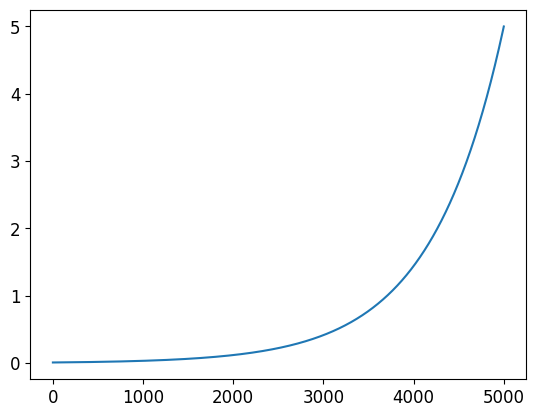

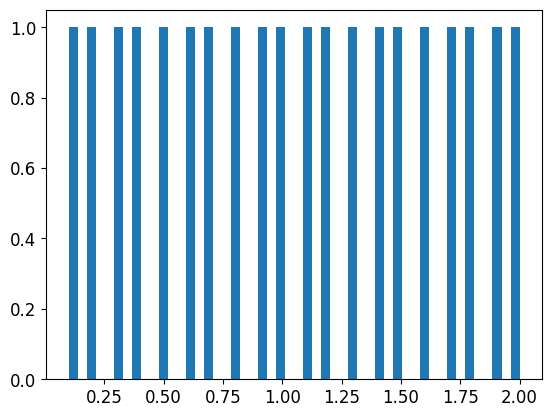

In [47]:
saturation_range = np.logspace(np.log10(0.01), np.log10(5), 5000)
plt.plot(saturation_range)
plt.show()

min_saturation = 0.1
max_saturation = 2.0
np.linspace(min_saturation, max_saturation, 1000)
bins = 50
binned = np.linspace(min_saturation, max_saturation, 20)
plt.hist(binned, bins=bins)
plt.show()

In [9]:
def get_results_2(model_dir_directory, results_file_name="results.txt"):
        acc_rgb_text_location = os.path.join(model_dir_directory, results_file_name)

        # Accuracy values from the text file
        acc_rgb_values_text = open(acc_rgb_text_location).read()

        miou_start_search = "mious:"
        iou_std_start_search = "iou_stds:"

        float_regex = r"[-+]?\d*\.\d+|\d+"

        # Parse accuracy values from the text file
        miou_values = []
        iou_std_values = []
        for i, line in enumerate(acc_rgb_values_text.split("\n")):
            if miou_start_search in line and iou_std_start_search in line:
                line_1 = line.split(miou_start_search)[1].split("],")[0]
                miou_values.append([float(x) for x in re.findall(float_regex, line_1)])
                line_2 = line.split(iou_std_start_search)[1].split("],")[0]
                iou_std_values.append([float(x) for x in re.findall(float_regex, line_2)])

        return miou_values, iou_std_values

def plot_experiment_errorbar(colors, x_labels, data, axvlines=[], figsize=(15, 10), xtick_rotation=0):
    plt.figure(figsize=figsize)
    rgb_mean = data["rgb_mean"]
    rgb_depth_mean = data["rgb_depth_mean"]
    rgb_std = None
    rgb_depth_std = None
    if "rgb_std" in data and "rgb_depth_std" in data:
        rgb_std = data["rgb_std"]
        rgb_depth_std = data["rgb_depth_std"]
    depth_mean = None
    depth_std = None
    if "depth_mean" in data and "depth_std" in data:
        depth_mean = data["depth_mean"]
        depth_std = data["depth_std"]

    num_classes = len(x_labels)
    bar_width = 0.2
    index = np.arange(num_classes)
    
    if rgb_std is not None and rgb_depth_std is not None:
        plt.errorbar(index + 0*bar_width, rgb_mean, yerr=rgb_std, fmt='o', color=colors[0], label='RGB')
        plt.errorbar(index + 1*bar_width, rgb_depth_mean, yerr=rgb_depth_std, fmt='o', color=colors[1], label='RGB-D')
    else:
        plt.bar(index + 0*bar_width, rgb_mean, bar_width, color=colors[0], label='RGB')
        plt.bar(index + 1*bar_width, rgb_depth_mean, bar_width, color=colors[1], label='RGB-D')
    if depth_mean is not None and depth_std is not None:
        plt.errorbar(index + 3*bar_width, depth_mean, yerr=depth_std, fmt='o', color=colors[2], label='Depth')

    min_data_value = min(min(rgb_mean), min(rgb_depth_mean))
    max_data_value = 100
    if rgb_std is not None and rgb_depth_std is not None:
        min_data_value = min_data_value - max(max(rgb_std), max(rgb_depth_std))
    if depth_mean is not None and depth_std is not None:
        min_data_value = min(min_data_value, min(depth_mean))
        max_data_value = max(max_data_value, max(depth_mean))

    # Add vertical sections
    previous_pos = 0.0
    current_pos = 0.0
    for axvline_data_object in axvlines:
        assert 'x' in axvline_data_object, "x key is missing in axvline_data_object"
        assert 'color' in axvline_data_object, "color key is missing in axvline_data_object"
        assert 'label' in axvline_data_object, "label key is missing in axvline_data_object"
        x = axvline_data_object['x']
        color = axvline_data_object['color']
        label = axvline_data_object['label']

        current_pos += x
        
        plt.fill_between(
            [(int)(previous_pos * num_classes), (int)(current_pos * num_classes)], 
            min_data_value, 
            max_data_value, 
            color=color, 
            alpha=0.15,
            label=label
        )

        previous_pos = current_pos


    plt.xlabel('Saturation')
    plt.ylabel('Mean Prediction IOU')
    plt.title('Mean Prediction IOU for Different Saturation Levels')
    plt.xticks(index + bar_width, x_labels, rotation=xtick_rotation)
    plt.legend()
    plt.show()

40 40


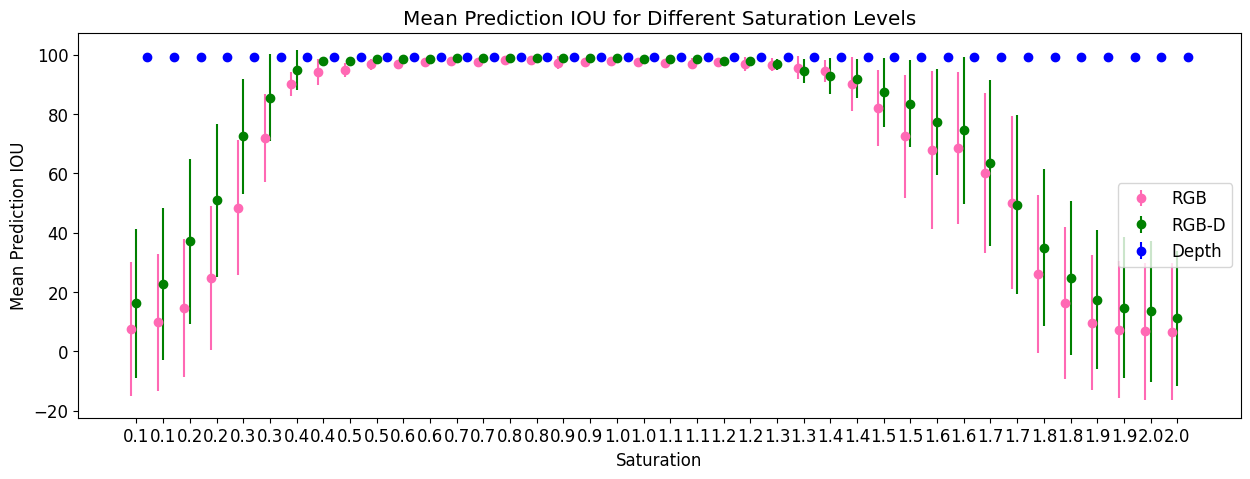

[0.34210526 0.47368421]


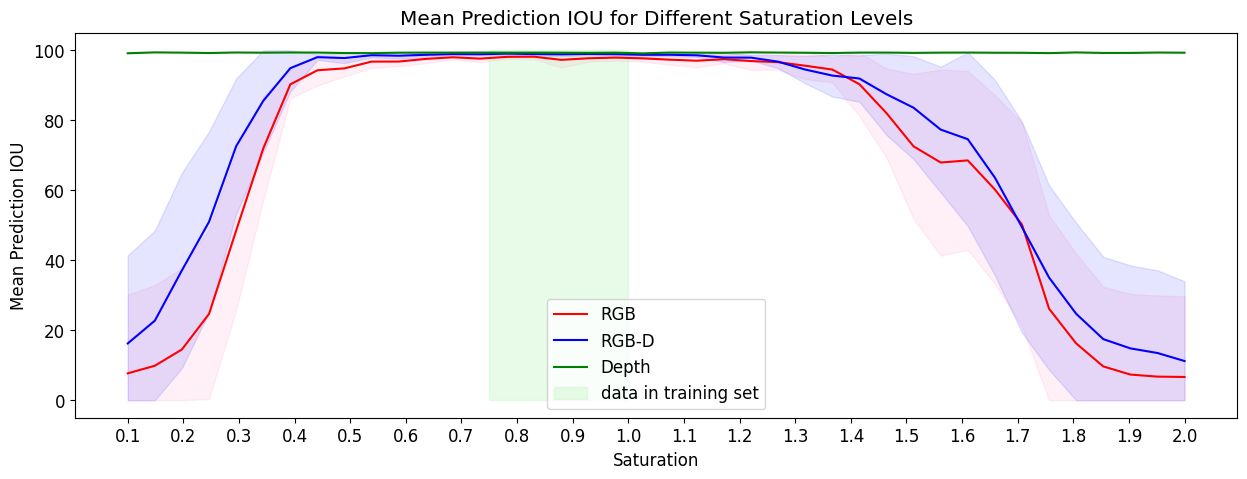

In [11]:
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_y_DFormer-Tiny\run_20240421-125539
saturation_gems_green_rgbd = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_y_DFormer-Tiny\run_20240421-125539"
# code\DFormer\checkpoints\SynthDet_new_black_back_green_saturation_gems_y_DFormer-Tiny\run_20240421-140440
saturation_gems_green_rgb = r"..\checkpoints\SynthDet_new_black_back_green_saturation_gems_y_DFormer-Tiny\run_20240421-140440"

saturation_gems_red_depth = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-182535"

miou_rgbd, std_rgbd = get_results_2(saturation_gems_green_rgbd)
miou_rgb, std_rgb = get_results_2(saturation_gems_green_rgb)
miou_depth, std_depth = get_results_2(saturation_gems_red_depth)

data = {
    "rgb_mean": np.array(miou_rgb[-1]),
    "rgb_depth_mean": np.array(miou_rgbd[-1]),
    "rgb_std": np.array(std_rgb[-1]),
    "rgb_depth_std": np.array(std_rgbd[-1]),
    "depth_mean": np.array(miou_depth[-1]),
    "depth_std": np.array(std_depth[-1]),
}

colors = ['#FF69B4', 'green', 'blue']
min_saturation = 0.1
max_saturation = 2.0
x_labels = np.linspace(min_saturation, max_saturation, 40)
x_labels = [f"{label:.1f}" for label in x_labels]
print(len(x_labels), len(data["rgb_mean"]))
plot_experiment_errorbar(colors, x_labels, data, figsize=(15, 5), xtick_rotation=0)

x_labels = np.linspace(min_saturation, max_saturation, 20)
x_labels = [f"{label:.1f}" for label in x_labels]

plt.figure(figsize=(15, 5))
plt.plot(data["rgb_mean"], label='RGB', color='red')
plt.plot(data["rgb_depth_mean"], label='RGB-D', color='blue')
plt.plot(data["depth_mean"], label='Depth', color='green')

plt.fill_between(
    range(len(data["rgb_mean"])), 
    np.maximum(data["rgb_mean"] - data["rgb_std"], 0),
    np.minimum(data["rgb_mean"] + data["rgb_std"], 100), 
    color='#FF69B4', alpha=0.1)
plt.fill_between(
    range(len(data["rgb_depth_mean"])), 
    np.maximum(data["rgb_depth_mean"] - data["rgb_depth_std"], 0), 
    np.minimum(data["rgb_depth_mean"] + data["rgb_depth_std"], 100), 
    color='blue', alpha=0.1)

data_in_train_x_positions = np.array([0.75, 1.0])
data_in_train_x_positions = (data_in_train_x_positions - 0.1) / (2.0-0.1)
print(data_in_train_x_positions)
plt.fill_between(
    [data_in_train_x_positions[0] * (len(data["rgb_mean"]) - 1), data_in_train_x_positions[1] * (len(data["rgb_mean"]) - 1)], 
    0, 100, 
    color='lightgreen', alpha=0.2, label='data in training set')

plt.xlabel('Saturation')

num_steps = len(x_labels)
locations = np.linspace(0, len(data["rgb_mean"]) - 1, num_steps)

plt.xticks(locations, x_labels)
plt.ylabel('Mean Prediction IOU')
plt.title('Mean Prediction IOU for Different Saturation Levels')
plt.legend()
plt.show()


40 40


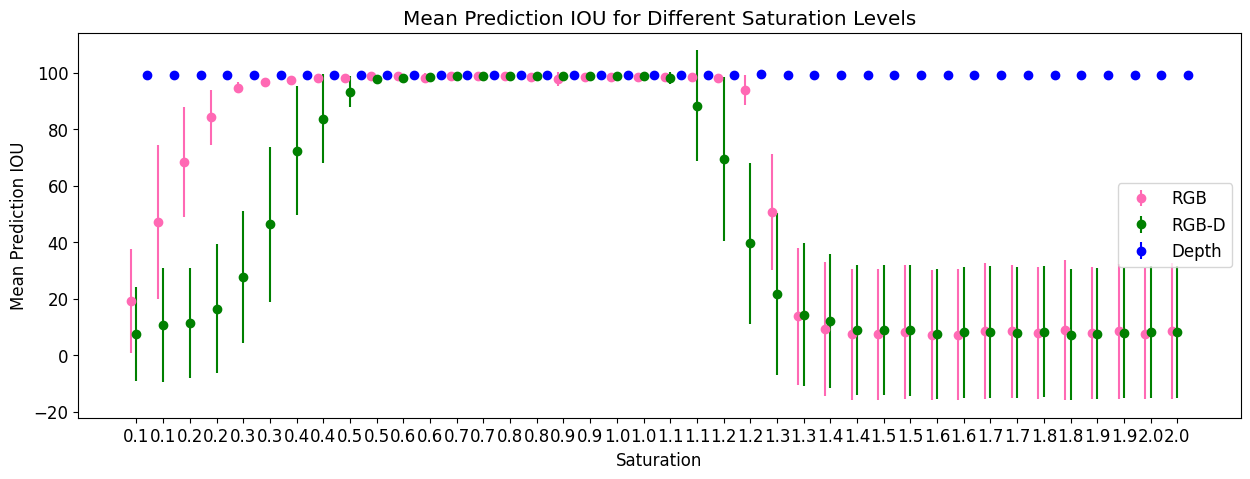

[0.34210526 0.47368421]


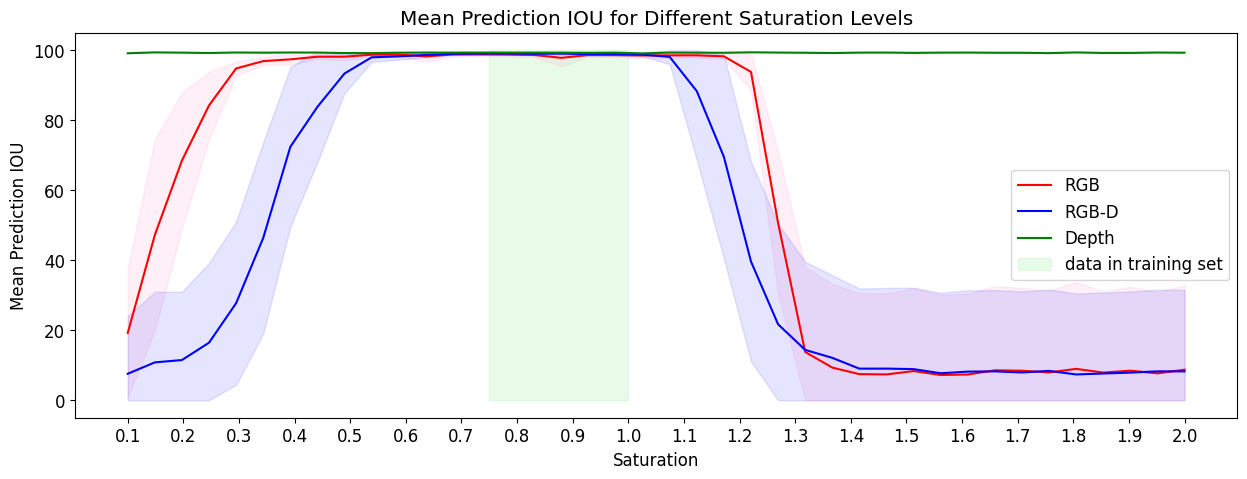

In [118]:
# code\DFormer\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-162727
saturation_gems_red_rgbd = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-162727"
# code\DFormer\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-172337
saturation_gems_red_rgb = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-172337"
# code\DFormer\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-182535
saturation_gems_red_depth = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-182535"

miou_rgbd, std_rgbd = get_results_2(saturation_gems_red_rgbd)
miou_rgb, std_rgb = get_results_2(saturation_gems_red_rgb)
miou_depth, std_depth = get_results_2(saturation_gems_red_depth)

data = {
    "rgb_mean": np.array(miou_rgb[-1]),
    "rgb_depth_mean": np.array(miou_rgbd[-1]),
    "rgb_std": np.array(std_rgb[-1]),
    "rgb_depth_std": np.array(std_rgbd[-1]),
    "depth_mean": np.array(miou_depth[-1]),
    "depth_std": np.array(std_depth[-1]),
}

colors = ['#FF69B4', 'green', 'blue']
x_labels = np.linspace(min_saturation, max_saturation, 40)
x_labels = [f"{label:.1f}" for label in x_labels]
print(len(x_labels), len(data["rgb_mean"]))
plot_experiment_errorbar(colors, x_labels, data, figsize=(15, 5), xtick_rotation=0)

x_labels = np.linspace(min_saturation, max_saturation, 20)
x_labels = [f"{label:.1f}" for label in x_labels]

plt.figure(figsize=(15, 5))
plt.plot(data["rgb_mean"], label='RGB', color='red')
plt.plot(data["rgb_depth_mean"], label='RGB-D', color='blue')
plt.plot(data["depth_mean"], label='Depth', color='green')

plt.fill_between(
    range(len(data["rgb_mean"])), 
    np.maximum(data["rgb_mean"] - data["rgb_std"], 0),
    np.minimum(data["rgb_mean"] + data["rgb_std"], 100), 
    color='#FF69B4', alpha=0.1)
plt.fill_between(
    range(len(data["rgb_depth_mean"])), 
    np.maximum(data["rgb_depth_mean"] - data["rgb_depth_std"], 0), 
    np.minimum(data["rgb_depth_mean"] + data["rgb_depth_std"], 100), 
    color='blue', alpha=0.1)

data_in_train_x_positions = np.array([0.75, 1.0])
data_in_train_x_positions = (data_in_train_x_positions - 0.1) / (2.0-0.1)
print(data_in_train_x_positions)
plt.fill_between(
    [data_in_train_x_positions[0] * (len(data["rgb_mean"]) - 1), data_in_train_x_positions[1] * (len(data["rgb_mean"]) - 1)], 
    0, 100, 
    color='lightgreen', alpha=0.2, label='data in training set')

plt.xlabel('Saturation')

num_steps = len(x_labels)
locations = np.linspace(0, len(data["rgb_mean"]) - 1, num_steps)

plt.xticks(locations, x_labels)
plt.ylabel('Mean Prediction IOU')
plt.title('Mean Prediction IOU for Different Saturation Levels')
plt.legend()
plt.show()


0.9524720893141945


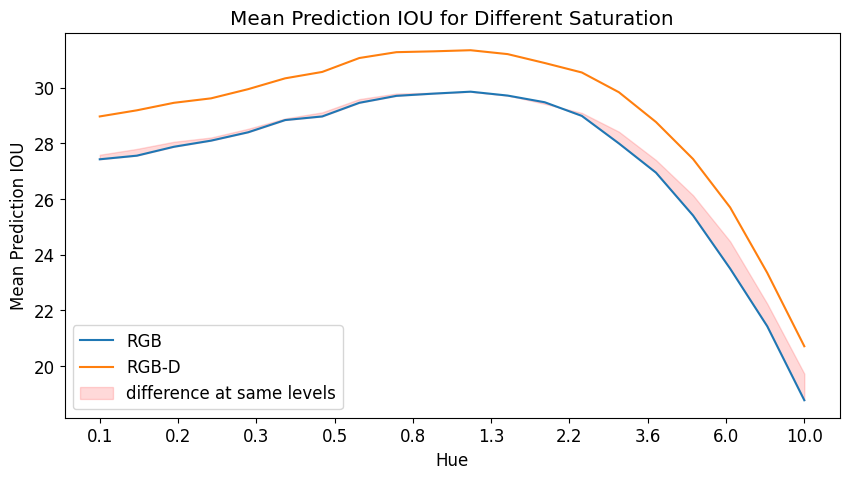

In [124]:
# code\DFormer\checkpoints\SUNRGBD_DFormer-Tiny\run_20240416-180209_RGBD
sunrgbd_rgbd = r"..\checkpoints\SUNRGBD_DFormer-Tiny\run_20240416-180209_RGBD"
# code\DFormer\checkpoints\SUNRGBD_DFormer-Tiny\run_20240416-224357_RGB
sunrgbd_rgb = r"..\checkpoints\SUNRGBD_DFormer-Tiny\run_20240416-224357_RGB"

# miou_rgb_values_sunrgbd, iou_std_rgb_values_sunrgbd = get_results_2(sunrgbd_rgbd, results_file_name="hue_tests.txt")
miou_rgb_depth_values_sunrgbd, iou_std_rgb_depth_values_sunrgbd = get_results_2(sunrgbd_rgbd, results_file_name="saturation_tests.txt")
miou_rgb_values_sunrgbd, iou_std_rgb_values_sunrgbd = get_results_2(sunrgbd_rgb, results_file_name="saturation_tests.txt")

miou_rgb_values_sunrgbd = np.concatenate(np.array(miou_rgb_values_sunrgbd))
iou_std_rgb_values_sunrgbd = np.concatenate(np.array(iou_std_rgb_values_sunrgbd))
miou_rgb_depth_values_sunrgbd = np.concatenate(np.array(miou_rgb_depth_values_sunrgbd))
iou_std_rgb_depth_values_sunrgbd = np.concatenate(np.array(iou_std_rgb_depth_values_sunrgbd))

data = {
    "rgb_mean": miou_rgb_values_sunrgbd,
    "rgb_depth_mean": miou_rgb_depth_values_sunrgbd,
}

# Experiment
max_value_rgb = np.max(miou_rgb_values_sunrgbd)
max_value_rgb_depth = np.max(miou_rgb_depth_values_sunrgbd)

difference_percentage = max_value_rgb / max_value_rgb_depth
print(difference_percentage)
miou_rgb_depth_shifted = miou_rgb_depth_values_sunrgbd * difference_percentage

# x_labels = [str(x) for x in saturation_values]
saturation_values = np.logspace(np.log10(0.1), np.log10(10), 10)
x_labels = [f"{label:.1f}" for label in saturation_values]

plt.figure(figsize=(10, 5))
plt.plot(range(len(miou_rgb_values_sunrgbd)), miou_rgb_values_sunrgbd, label='RGB')
plt.plot(range(len(miou_rgb_depth_values_sunrgbd)), miou_rgb_depth_values_sunrgbd, label='RGB-D')

plt.fill_between(range(len(miou_rgb_values_sunrgbd)), miou_rgb_depth_shifted, miou_rgb_values_sunrgbd, color='red', alpha=0.15, label='difference at same levels')

plt.title("Mean Prediction IOU for Different Saturation")
plt.xlabel("Hue")
plt.ylabel("Mean Prediction IOU")
# plt.xticks(range(len(x_labels)), x_labels)
plt.xticks(np.linspace(0, len(miou_rgb_values_sunrgbd) -1, len(x_labels)), x_labels)
plt.legend()
plt.show()

40 40


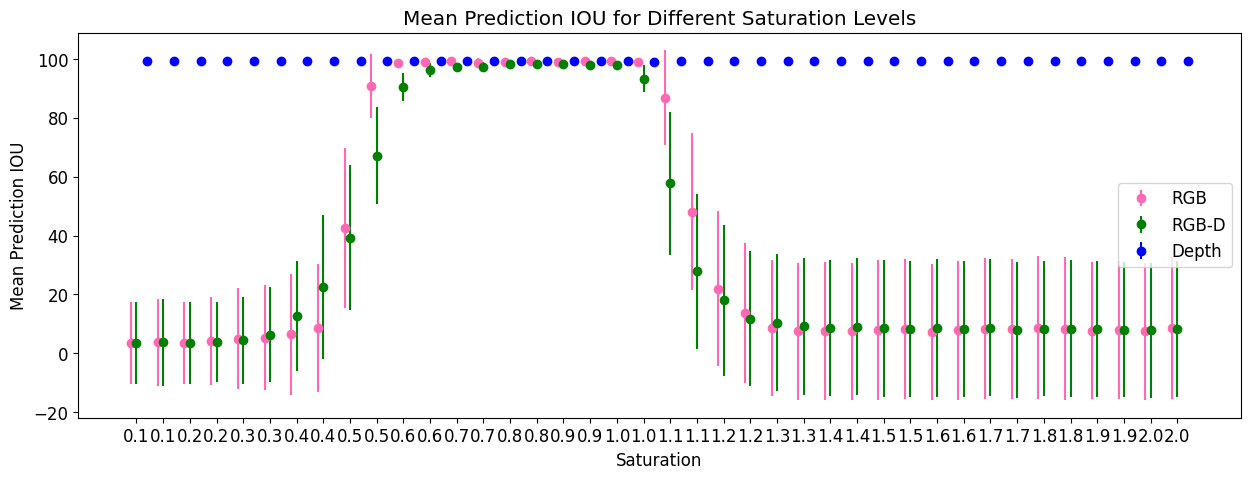

[0.34210526 0.47368421]


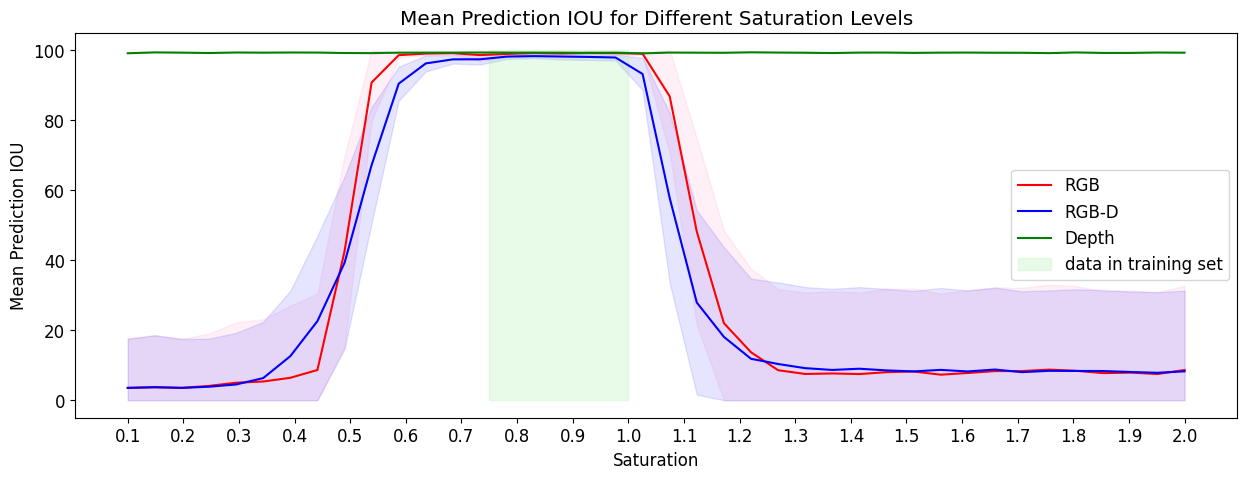

In [119]:
# code\DFormer\checkpoints\SynthDet_new_black_back_blue_saturation_gems_y_DFormer-Tiny\run_20240421-201413
saturation_gems_blue_rgbd = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_y_DFormer-Tiny\run_20240421-201413"
# code\DFormer\checkpoints\SynthDet_new_black_back_blue_saturation_gems_y_DFormer-Tiny\run_20240421-212241
saturation_gems_blue_rgb = r"..\checkpoints\SynthDet_new_black_back_blue_saturation_gems_y_DFormer-Tiny\run_20240421-212241"

# code\DFormer\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-182535
saturation_gems_depth = r"..\checkpoints\SynthDet_new_black_back_red_saturation_gems_y_DFormer-Tiny\run_20240421-182535"

miou_rgbd, std_rgbd = get_results_2(saturation_gems_blue_rgbd)
miou_rgb, std_rgb = get_results_2(saturation_gems_blue_rgb)
miou_depth, std_depth = get_results_2(saturation_gems_depth)

data = {
    "rgb_mean": np.array(miou_rgb[-1]),
    "rgb_depth_mean": np.array(miou_rgbd[-1]),
    "rgb_std": np.array(std_rgb[-1]),
    "rgb_depth_std": np.array(std_rgbd[-1]),
    "depth_mean": np.array(miou_depth[-1]),
    "depth_std": np.array(std_depth[-1]),
}

colors = ['#FF69B4', 'green', 'blue']
x_labels = np.linspace(min_saturation, max_saturation, 40)
x_labels = [f"{label:.1f}" for label in x_labels]
print(len(x_labels), len(data["rgb_mean"]))
plot_experiment_errorbar(colors, x_labels, data, figsize=(15, 5), xtick_rotation=0)

x_labels = np.linspace(min_saturation, max_saturation, 20)
x_labels = [f"{label:.1f}" for label in x_labels]

plt.figure(figsize=(15, 5))
plt.plot(data["rgb_mean"], label='RGB', color='red')
plt.plot(data["rgb_depth_mean"], label='RGB-D', color='blue')
plt.plot(data["depth_mean"], label='Depth', color='green')

plt.fill_between(
    range(len(data["rgb_mean"])), 
    np.maximum(data["rgb_mean"] - data["rgb_std"], 0),
    np.minimum(data["rgb_mean"] + data["rgb_std"], 100), 
    color='#FF69B4', alpha=0.1)
plt.fill_between(
    range(len(data["rgb_depth_mean"])), 
    np.maximum(data["rgb_depth_mean"] - data["rgb_depth_std"], 0), 
    np.minimum(data["rgb_depth_mean"] + data["rgb_depth_std"], 100), 
    color='blue', alpha=0.1)

data_in_train_x_positions = np.array([0.75, 1.0])
data_in_train_x_positions = (data_in_train_x_positions - 0.1) / (2.0-0.1)
print(data_in_train_x_positions)
plt.fill_between(
    [data_in_train_x_positions[0] * (len(data["rgb_mean"]) - 1), data_in_train_x_positions[1] * (len(data["rgb_mean"]) - 1)], 
    0, 100, 
    color='lightgreen', alpha=0.2, label='data in training set')

plt.xlabel('Saturation')

num_steps = len(x_labels)
locations = np.linspace(0, len(data["rgb_mean"]) - 1, num_steps)

plt.xticks(locations, x_labels)
plt.ylabel('Mean Prediction IOU')
plt.title('Mean Prediction IOU for Different Saturation Levels')
plt.legend()
plt.show()

c:\Users\Pasca\anaconda3\envs\dformer_original\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(730, 530)
torch.Size([3, 530, 730])
torch.Size([3, 530, 730])
torch.Size([3, 530, 730])
torch.Size([3, 530, 730])
torch.Size([3, 530, 730])
torch.Size([3, 530, 730])


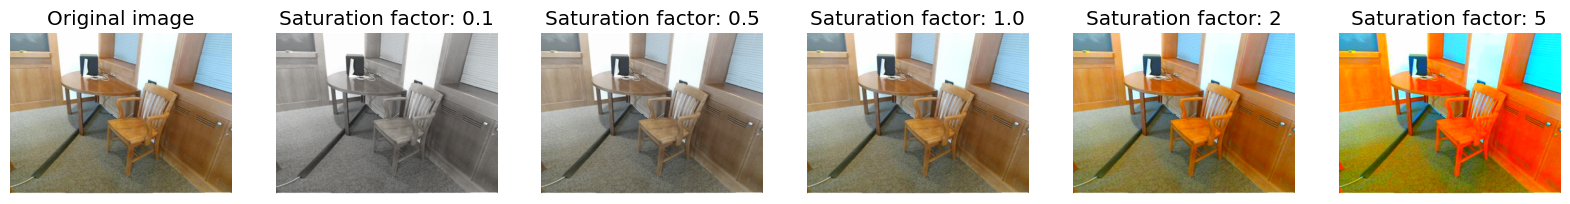

In [125]:
SUNRGBD_path = r"..\datasets\SUNRGBD\RGB_original"

example = SUNRGBD_path + r"\test_52.jpg"

import PIL.Image as Image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

image = Image.open(example)
print(image.size)
image = F.to_tensor(image)
print(image.shape)

fig, ax = plt.subplots(1, 6, figsize=(20, 10))
ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Original image")
ax[0].axis('off')
saturation_factors = [0.1, 0.5, 1.0, 2, 5]
for i, factor in enumerate(saturation_factors):
    saturation = F.adjust_saturation(image, factor)
    print(saturation.shape)
    ax[i + 1].imshow(saturation.permute(1, 2, 0))
    ax[i + 1].set_title(f"Saturation factor: {factor}")
    ax[i + 1].axis('off')

plt.show()


In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib

def get_saturation(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image from BGR to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Compute the saturation
    saturation = np.mean(hsv[:, :, 1])

    return saturation

def get_saturation_values(dataset_path, split='test'):

    saturation_values = []
    paths = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.startswith(split)]
    paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    saturation_values = [get_saturation(path) for path in paths]

    return saturation_values

def plot_saturation_values(saturation_values, title="", train_split = 0.42857):
    font = {'family': 'sans-serif',
        'size'   : 12}

    matplotlib.rc('font', **font)

    plt.figure(figsize=(20, 10))
    # plt.hist(saturation_values, bins=20)
    plt.plot(saturation_values, 'o', label='Saturation values')
    min_saturation = min(saturation_values) - 10
    max_saturation = max(saturation_values) + 10
    # plt.axvline(x=train_split * len(saturation_values), color='r', linestyle='--', label='Train split')
    if train_split is not None:
        plt.fill_between([0, train_split * len(saturation_values)], min_saturation, max_saturation, color='red', alpha=0.1, label='data in training set')
        plt.fill_between([train_split * len(saturation_values), len(saturation_values)], min_saturation, max_saturation, color='blue', alpha=0.1, label='data outside training set')
    plt.title("Saturation values distribution of " + title + " dataset")
    plt.xlabel("Data point")
    plt.ylabel("Saturation value")
    plt.legend()
    plt.show()

In [10]:
path = r"..\datasets\SynthDet_new_black_back_red_saturation_gems\RGB"
saturation_values = get_saturation_values(path)

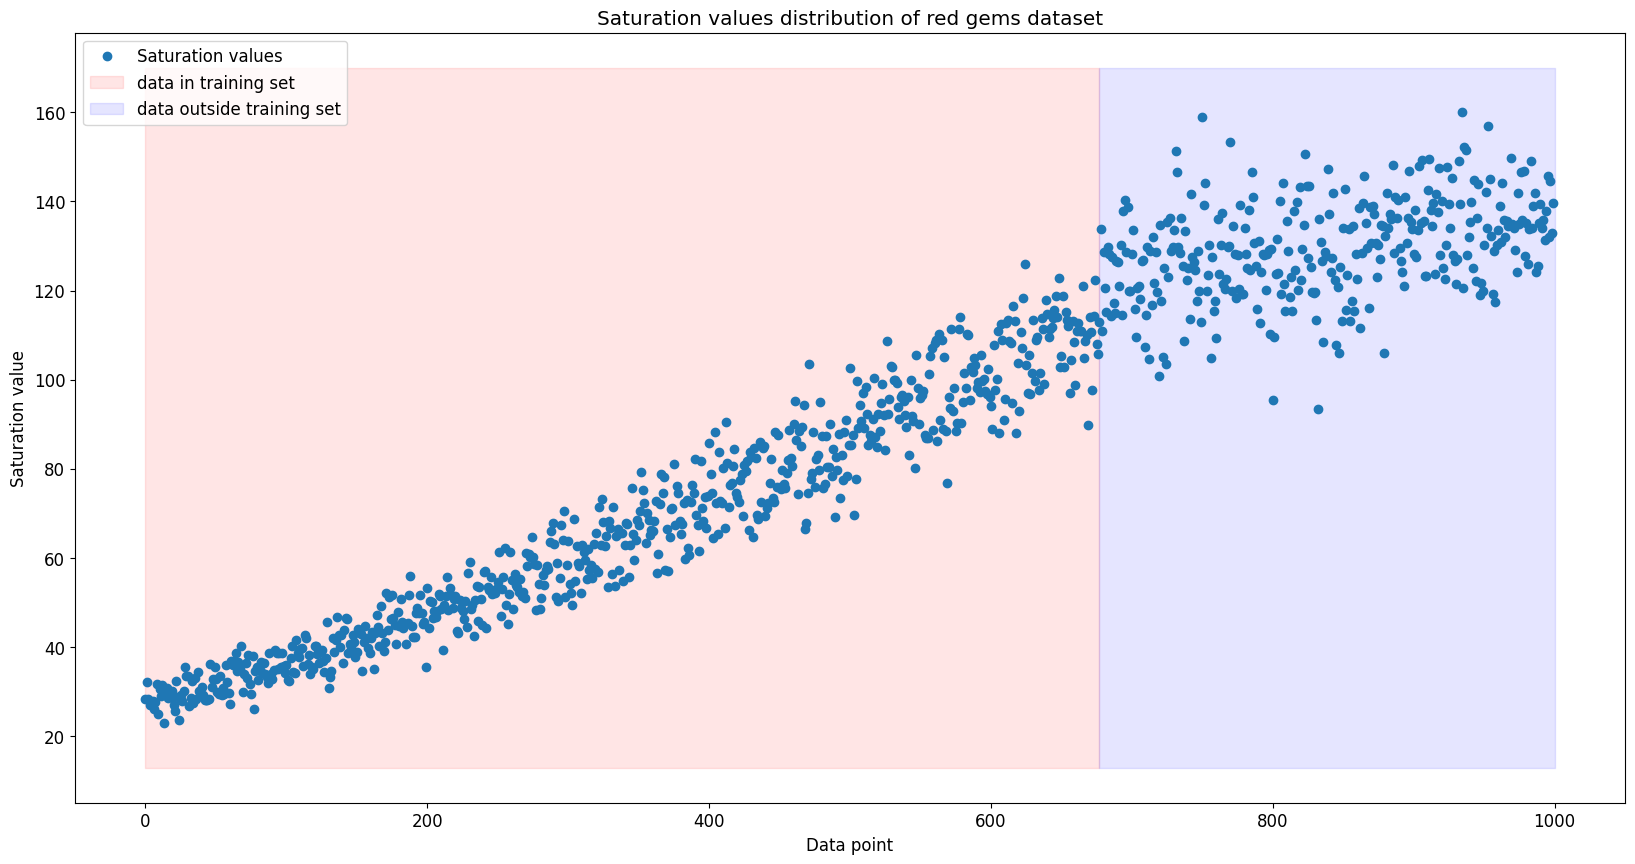

677


In [11]:
plot_saturation_values(saturation_values, title="red gems", train_split=677/1000)
saturation_range = np.logspace(np.log10(0.1), np.log10(3.0), 1000)
print(np.where(saturation_range > 1.0)[0][0])

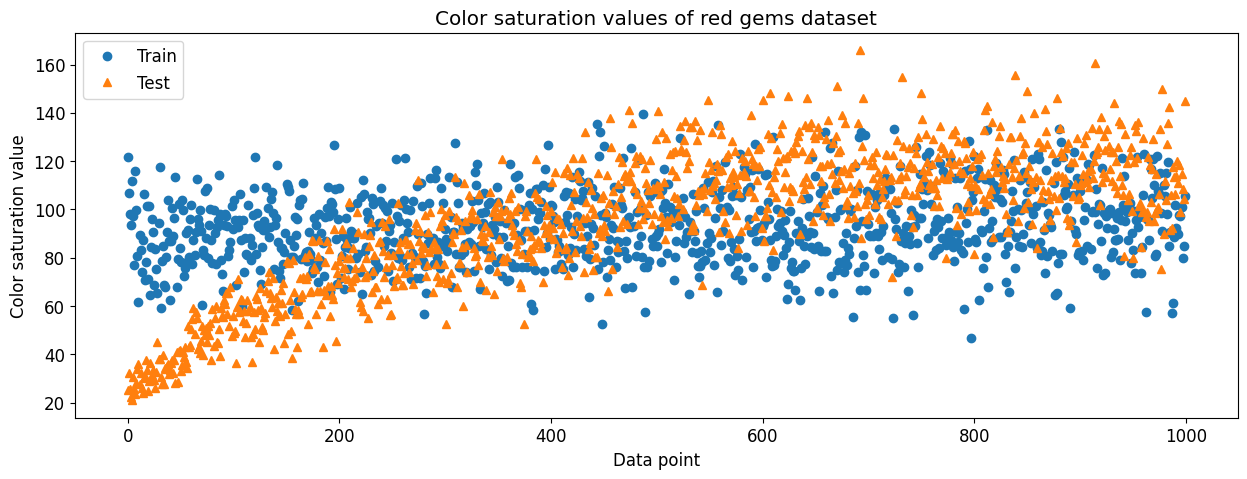

In [106]:
# code\DFormer\datasets\SynthDet_new_black_back_red_saturation_gems_y\RGB
red_saturation_gems_path = r"..\datasets\SynthDet_new_black_back_red_saturation_gems_y\RGB"
red_saturation_gems_values_train = get_saturation_values(red_saturation_gems_path, split='train')
red_saturation_gems_values_test = get_saturation_values(red_saturation_gems_path, split='test')

plt.figure(figsize=(15, 5))
plt.plot(red_saturation_gems_values_train, 'o', label='Train')
plt.plot(red_saturation_gems_values_test, '^', label='Test')
plt.xlabel("Data point")
plt.ylabel("Color saturation value")
plt.title("Color saturation values of red gems dataset")
plt.legend()
plt.show()


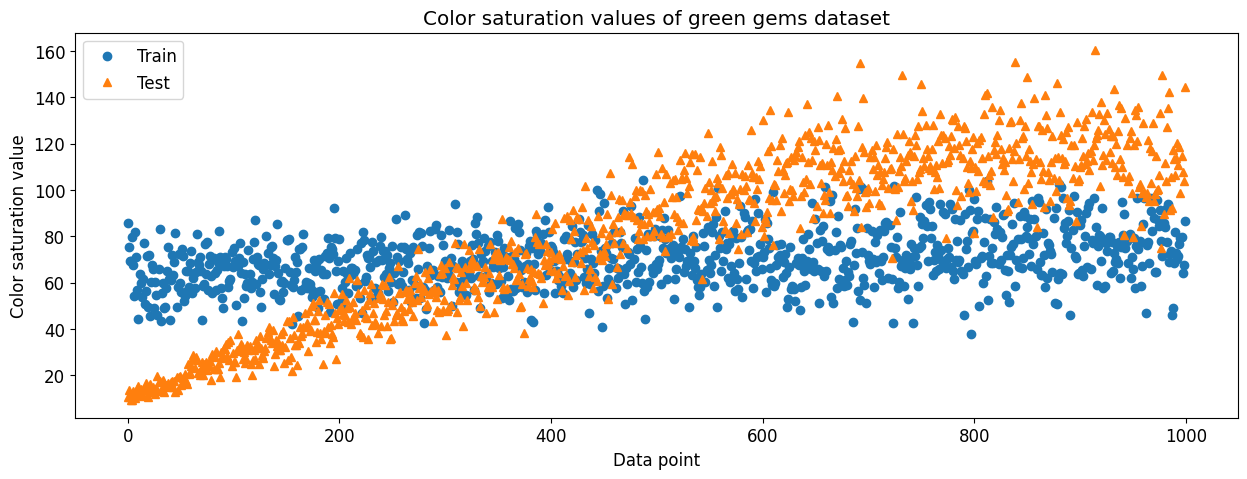

In [107]:
# code\DFormer\datasets\SynthDet_new_black_back_red_saturation_gems_y\RGB
red_saturation_gems_path = r"..\datasets\SynthDet_new_black_back_green_saturation_gems_y\RGB"
red_saturation_gems_values_train = get_saturation_values(red_saturation_gems_path, split='train')
red_saturation_gems_values_test = get_saturation_values(red_saturation_gems_path, split='test')

plt.figure(figsize=(15, 5))
plt.plot(red_saturation_gems_values_train, 'o', label='Train')
plt.plot(red_saturation_gems_values_test, '^', label='Test')
plt.xlabel("Data point")
plt.ylabel("Color saturation value")
plt.title("Color saturation values of green gems dataset")
plt.legend()
plt.show()

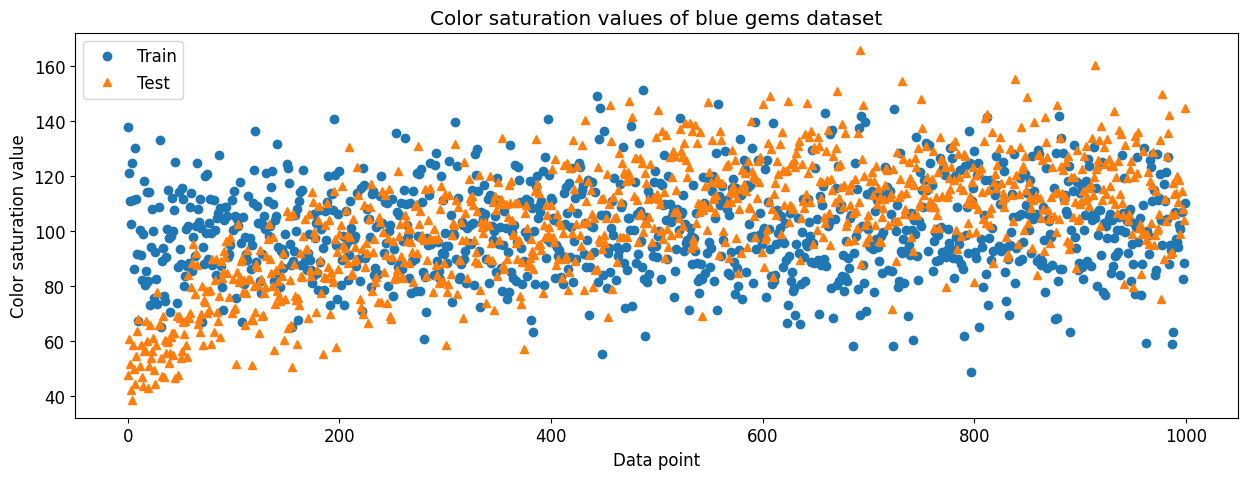

In [108]:
red_saturation_gems_path = r"..\datasets\SynthDet_new_black_back_blue_saturation_gems_y\RGB"
red_saturation_gems_values_train = get_saturation_values(red_saturation_gems_path, split='train')
red_saturation_gems_values_test = get_saturation_values(red_saturation_gems_path, split='test')

plt.figure(figsize=(15, 5))
plt.plot(red_saturation_gems_values_train, 'o', label='Train')
plt.plot(red_saturation_gems_values_test, '^', label='Test')
plt.xlabel("Data point")
plt.ylabel("Color saturation value")
plt.title("Color saturation values of blue gems dataset")
plt.legend()
plt.show()

In [12]:
path = r"..\datasets\SynthDet_new_black_back_green_saturation_gems\RGB"
saturation_values_2 = get_saturation_values(path)

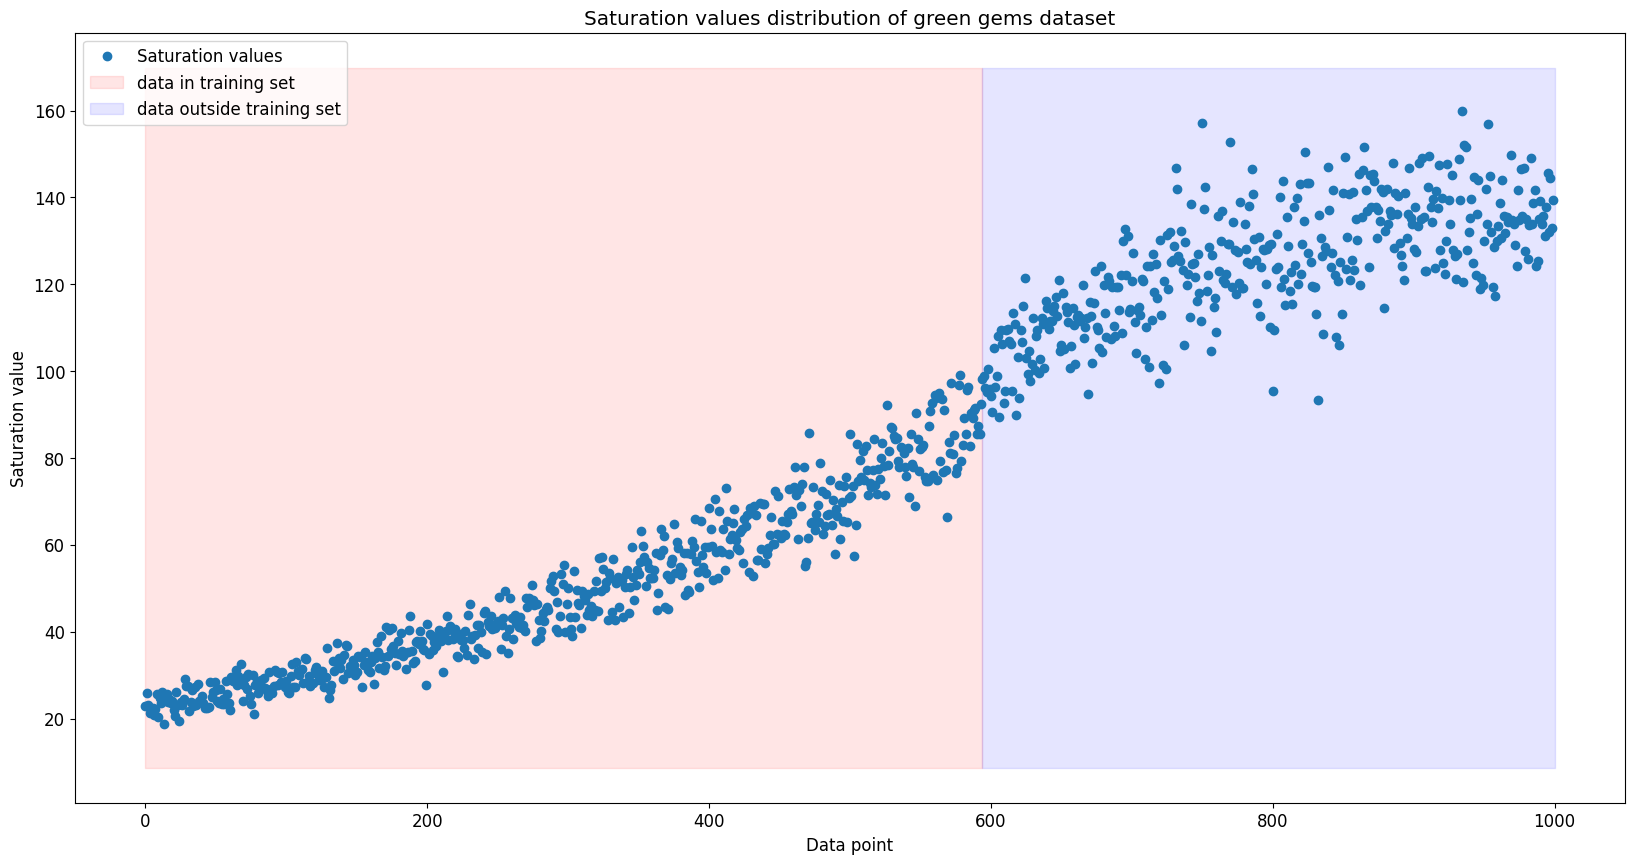

594


In [13]:
plot_saturation_values(saturation_values_2, title="green gems", train_split=594/1000)
saturation_range = np.logspace(np.log10(0.2), np.log10(3.0), 1000)
print(np.where(saturation_range > 1.0)[0][0])

In [49]:
path = r"..\datasets\SynthDet_new_black_back_blue_saturation_gems\RGB"
saturation_values_3 = get_saturation_values(path)

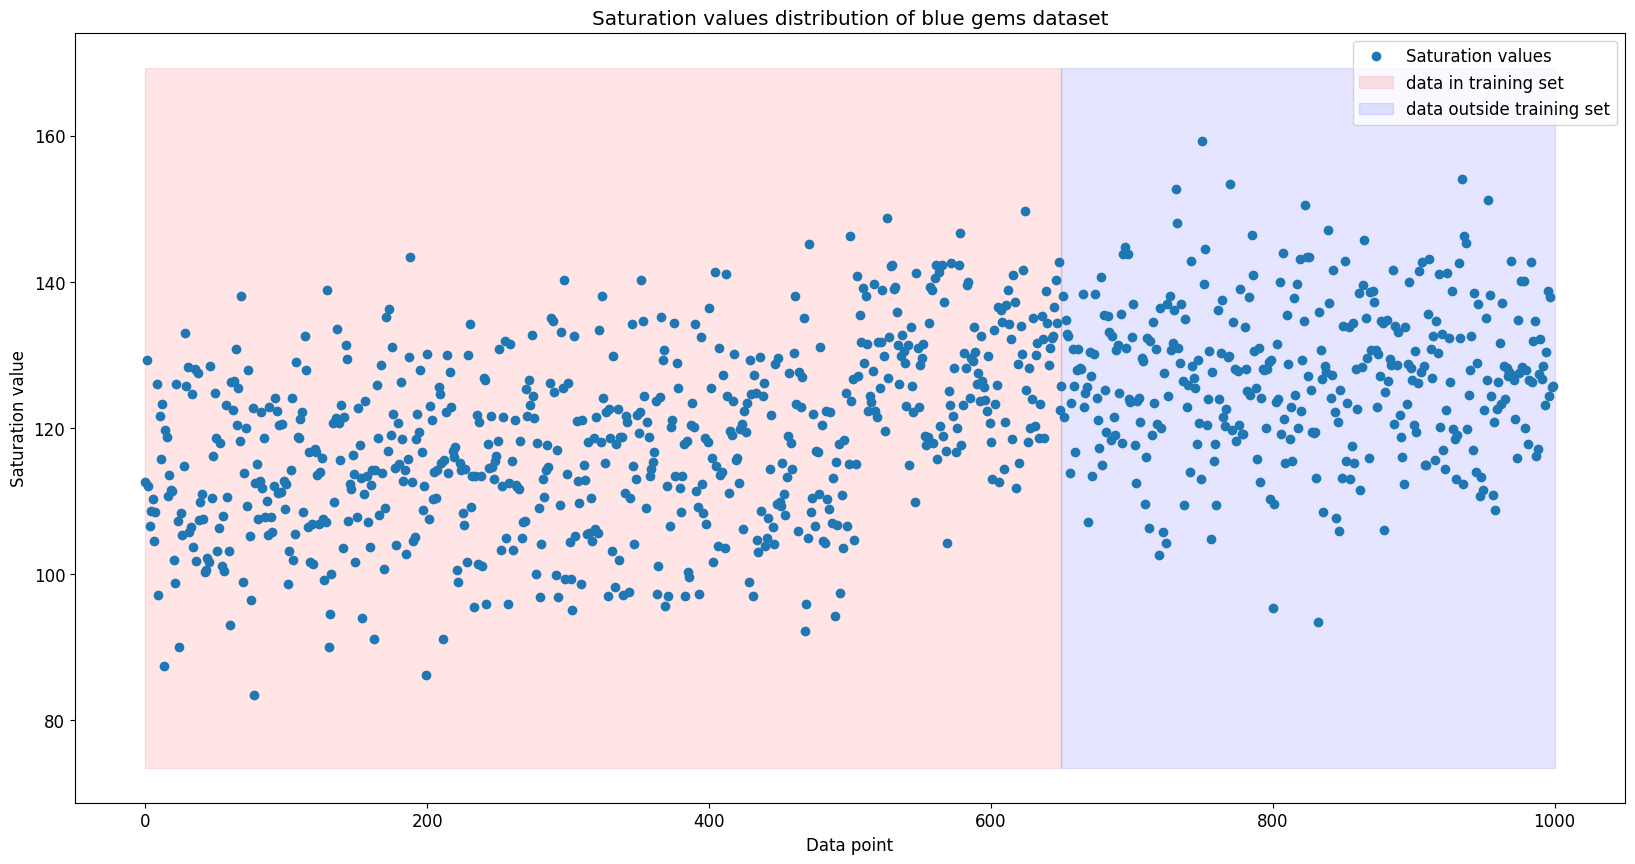

677


In [50]:
plot_saturation_values(saturation_values_3, title="blue gems", train_split=650/1000)
saturation_range = np.logspace(np.log10(0.1), np.log10(3.0), 1000)
print(np.where(saturation_range > 1.0)[0][0])

In [51]:
path = r"..\datasets\SynthDet_new_black_back_blue_saturation_gems\RGB"
saturation_values_train_blue = get_saturation_values(path, split='train')

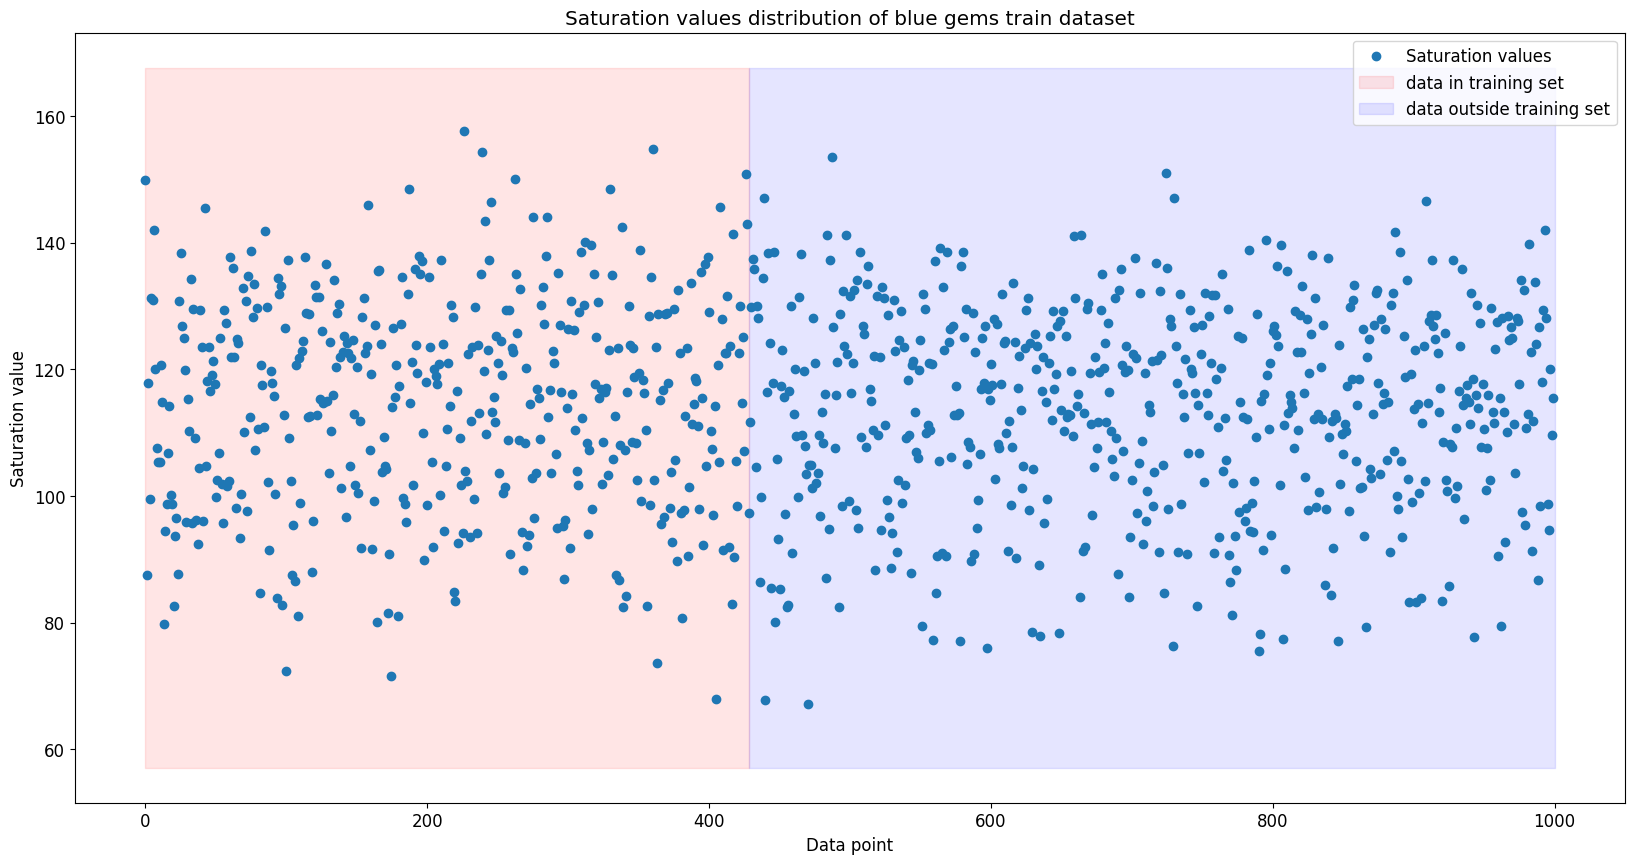

In [52]:
plot_saturation_values(saturation_values_train_blue, title="blue gems train")

In [30]:
path = r"..\datasets\SUNRGBD\RGB"

saturation_values_sunrgbd = get_saturation_values(path)

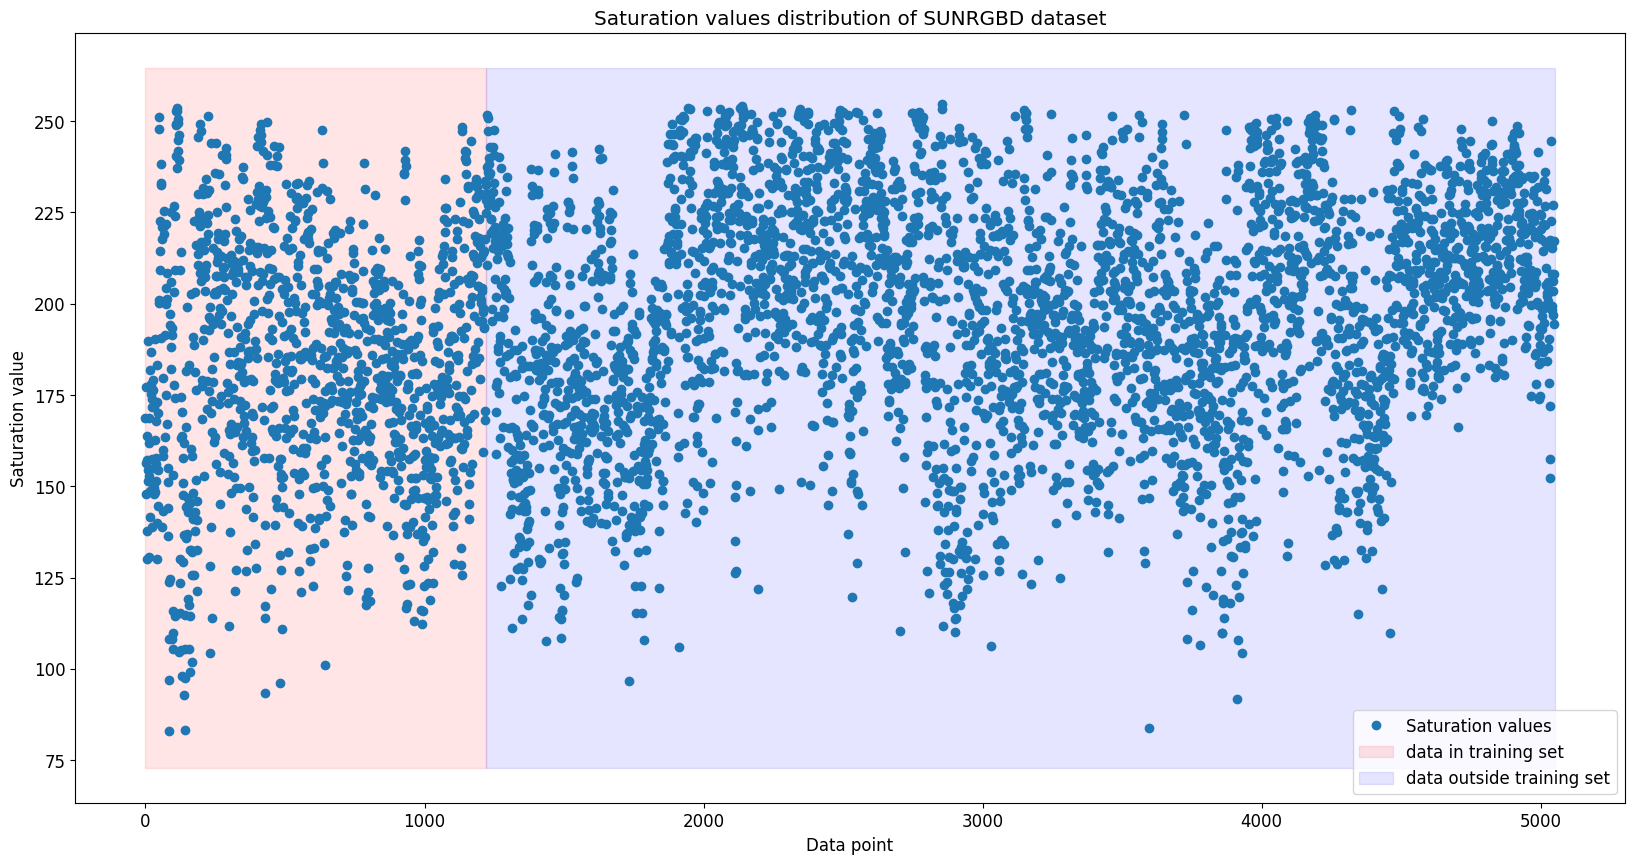

In [31]:
plot_saturation_values(saturation_values_sunrgbd, title="SUNRGBD", train_split=0.24137)

In [32]:
original_sunrgbd_path = r"..\datasets\SUNRGBD\RGB_original"

saturation_values_sunrgbd_original = get_saturation_values(original_sunrgbd_path, split='test')

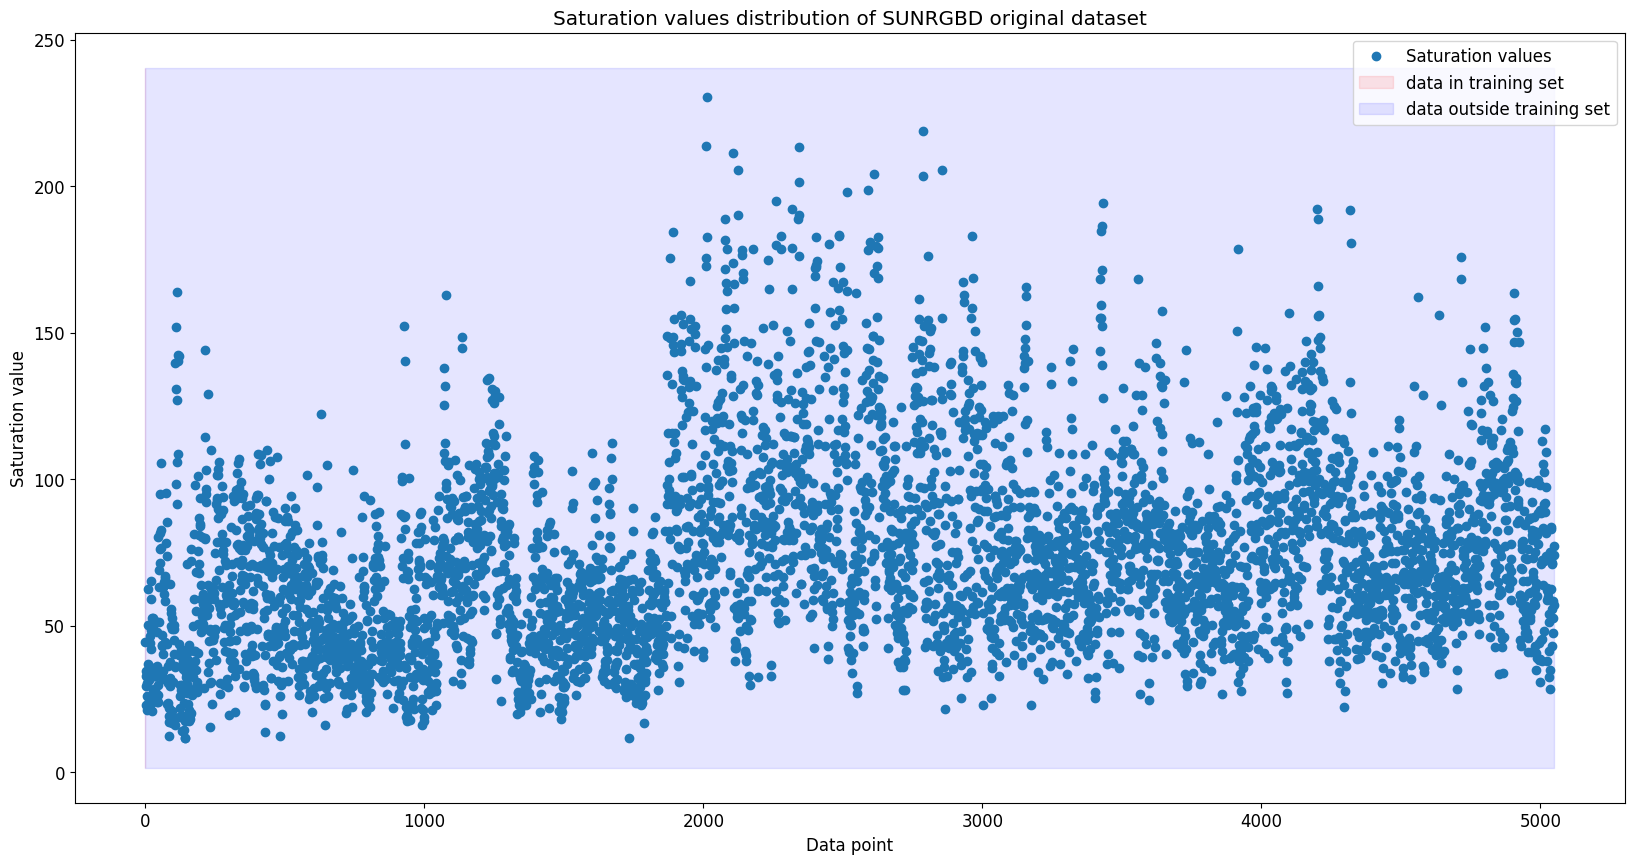

In [33]:
plot_saturation_values(saturation_values_sunrgbd_original, title="SUNRGBD original", train_split=0)

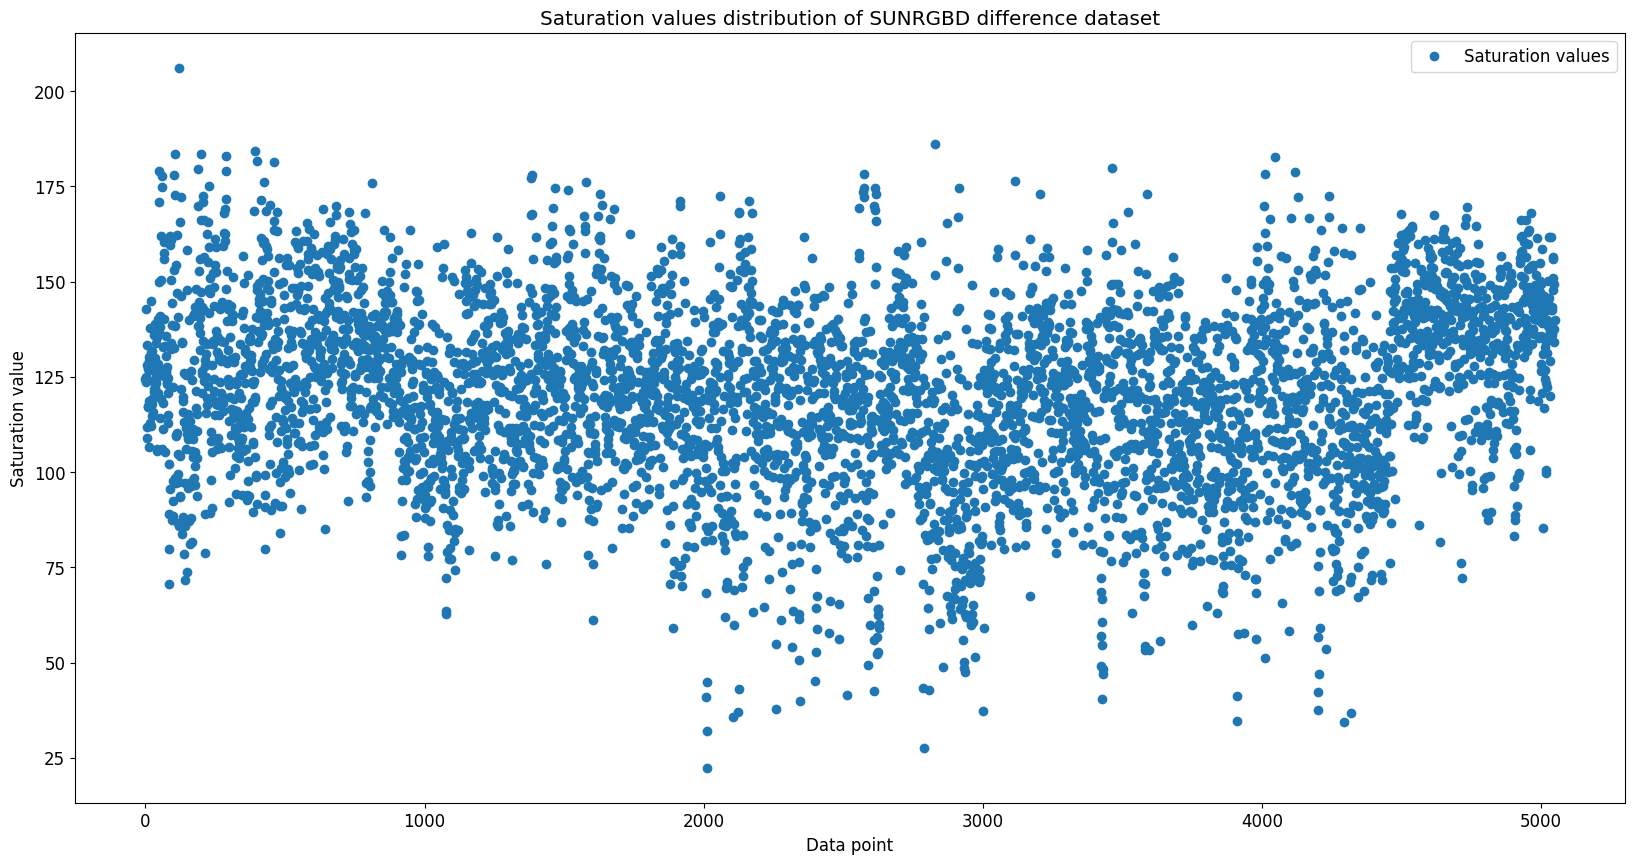

In [34]:
Difference_sunrgbd = np.array(saturation_values_sunrgbd) - np.array(saturation_values_sunrgbd_original)

plot_saturation_values(Difference_sunrgbd, title="SUNRGBD difference", train_split=None)

In [36]:
sunrgbd_path = r"..\datasets\SUNRGBD\RGB"
saturation_values = get_saturation_values(sunrgbd_path)

[   0    1    2 ... 5045 5046 5047]
5050 1941
193.4158556126462 193.94341123638836


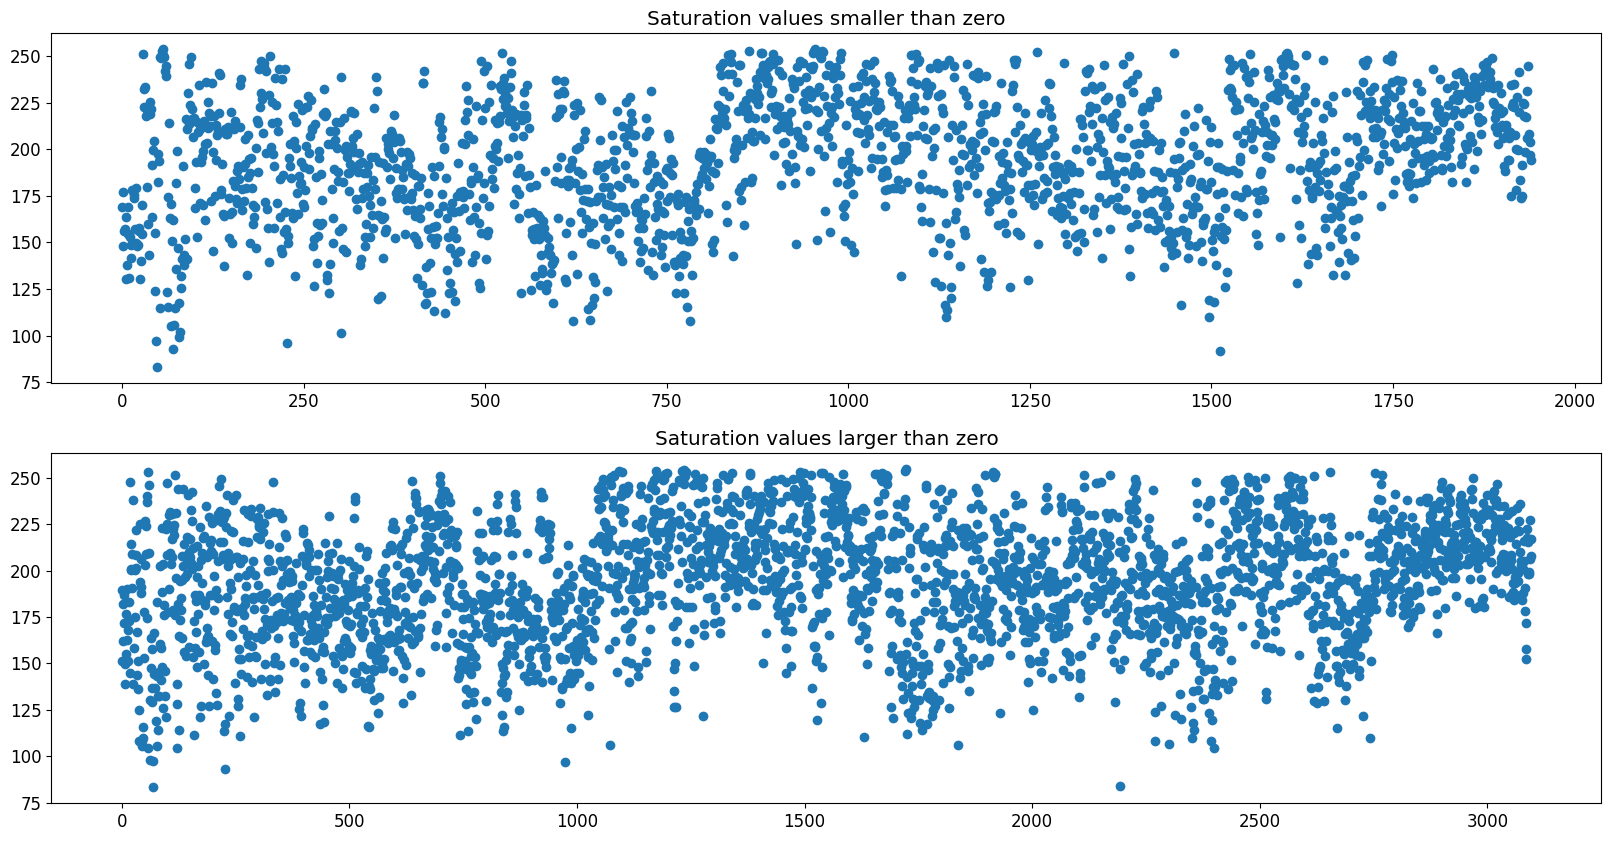

In [40]:
difference = np.array(pred_iou_rgb_depth_values) - np.array(pred_iou_rgb_values)
images_smaller_than_zero = np.argwhere(difference < 0)[:, 0]
print(images_smaller_than_zero)
print(len(saturation_values), len(images_smaller_than_zero))
saturation_values_smaller_than_zero = [saturation_values[index] for index in images_smaller_than_zero]

images_larger_than_zero = np.argwhere(difference > 0)[:, 0]
saturation_values_larger_than_zero = [saturation_values[index] for index in images_larger_than_zero]

print(np.average(saturation_values_smaller_than_zero), np.average(saturation_values_larger_than_zero))

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(saturation_values_smaller_than_zero, 'o', label='Saturation values')
ax[0].set_title("Saturation values smaller than zero")
ax[1].plot(saturation_values_larger_than_zero, 'o', label='Saturation values')
ax[1].set_title("Saturation values larger than zero")

plt.show()


In [249]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def get_class_distribution(label_dir, num_classes=38, split='train'):
    labels = [os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.startswith(split)]
    labels.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    num_labels = len(labels)
    classes = np.zeros((num_labels, num_classes))
    for i,label in enumerate(labels):
        label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)
        classes_in_label = np.unique(label)
        # Add one for every class that is present in the label
        for class_in_label in classes_in_label:
            classes[i, class_in_label] += 1

    class_distribution = np.sum(classes, axis=0)

    return classes, class_distribution, num_classes

def plot_class_distribution(classes, class_distribution, num_classes=38):
    fig, ax = plt.subplots(2, 1, figsize=(20, 15))
    ax[0].bar(range(num_classes), class_distribution)
    ax[0].set_title("Class distribution")
    ax[0].set_xlabel("Class")
    ax[0].set_ylabel("Number of occurrences")

    # Create a stacked percentage area chart, where the x axis is the data point in the dataset, and the y axis shows a layer of 1 if a class is present in the label, and 0 otherwise
    stacked_classes = np.zeros_like(classes)
    stacked_classes[classes > 0] = 1
    # sns.heatmap(stacked_classes.T, ax=ax[1], cmap='viridius', cbar=False)
    ax[1].imshow(stacked_classes.T, aspect='auto', cmap='binary', interpolation='nearest')
    ax[1].set_title("Class occurrences")
    ax[1].set_xlabel("Data point")
    ax[1].set_ylabel("Occurrence")
    ax[1].legend()
    
    plt.show()



In [243]:
original_sunrgbd_path = r"..\datasets\SUNRGBD\labels"

classes, class_distribution, num_classes = get_class_distribution(original_sunrgbd_path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


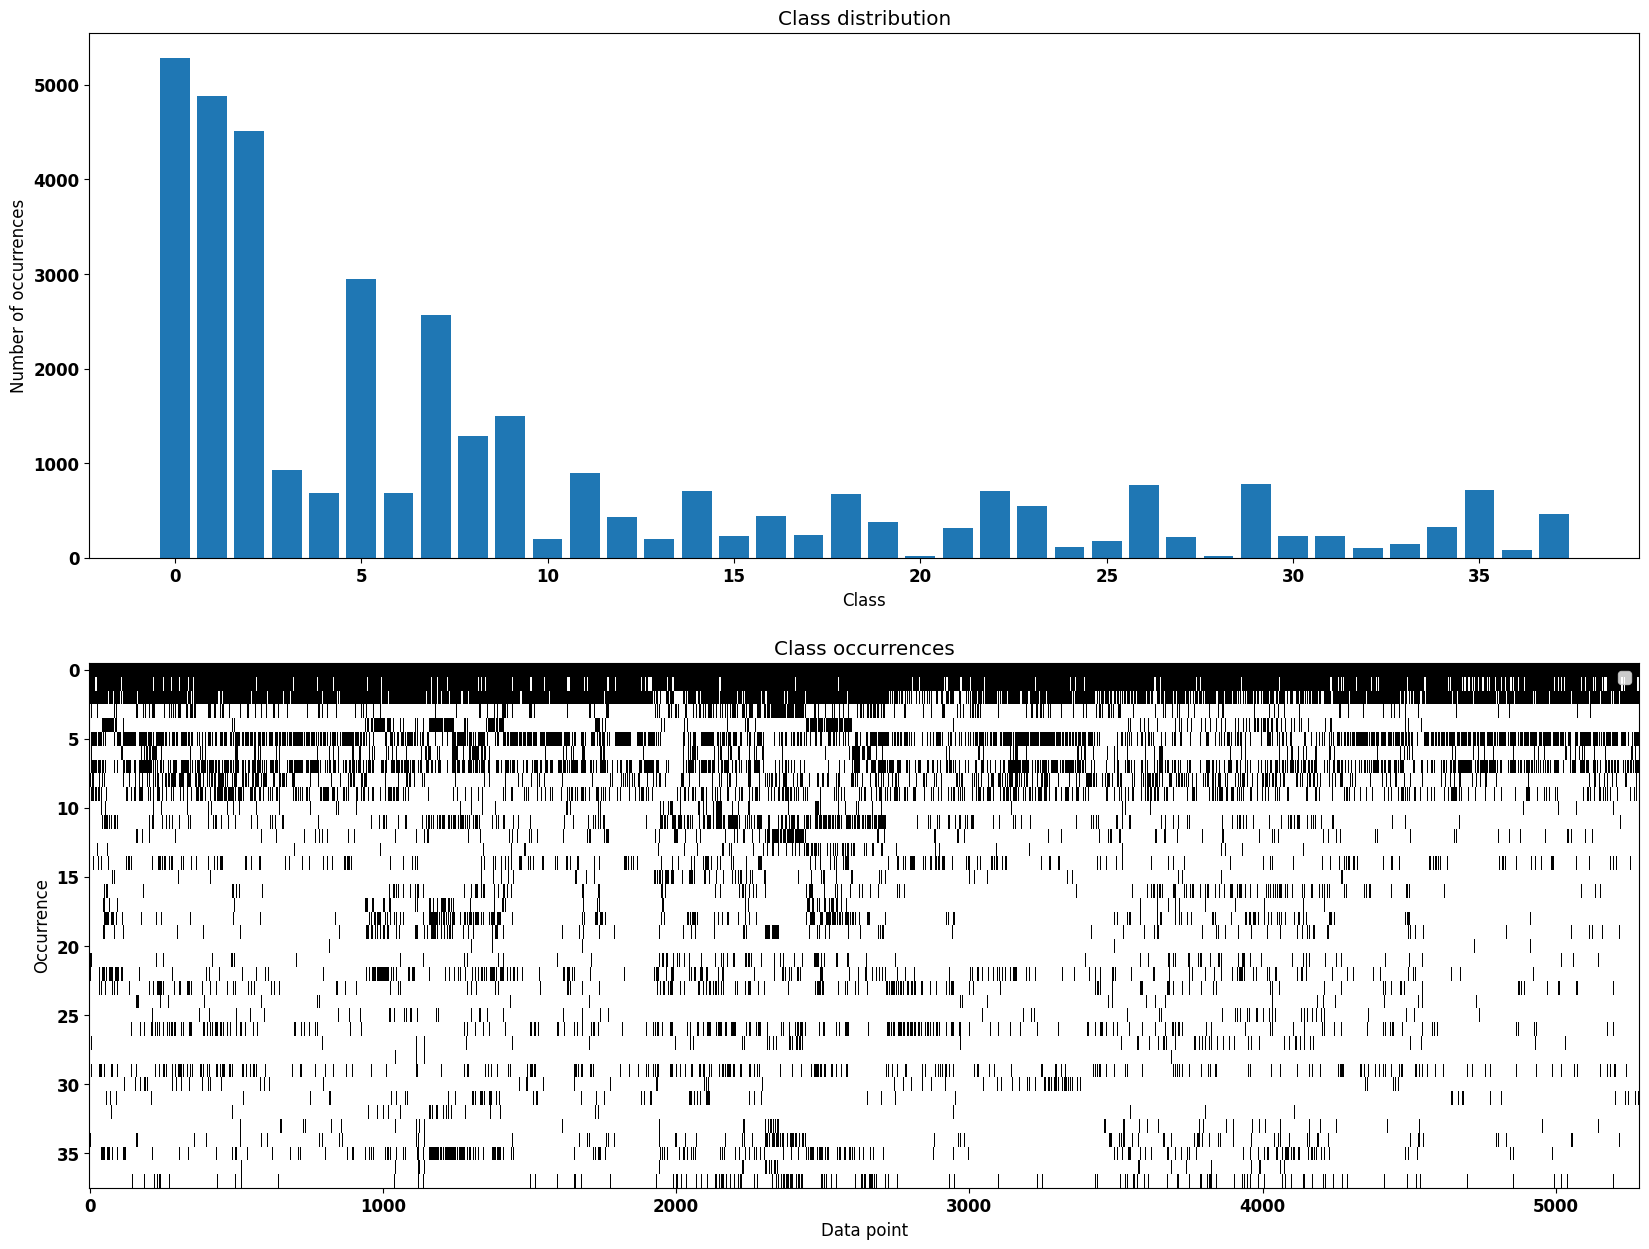

In [250]:
plot_class_distribution(classes, class_distribution, num_classes)

In [17]:
import os
import shutil
import numpy as np
import cv2

def adapt_channels(image, source_channel, target_channel):
    # Swap the channels of the image
    image[:, :, target_channel] = image[:, :, source_channel]

    return image

def copy_files(source, destination):
    files = [os.path.join(source, file) for file in os.listdir(source)]
    files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    for i, file in enumerate(files):
        image = cv2.imread(file)
        # Swap the green channel for the blue channel
        image = adapt_channels(image, 1, 0)

        # Save the image to the destination
        new_filename = os.path.join(destination, os.path.basename(file))

        cv2.imwrite(new_filename, image)

# code\DFormer\datasets\SynthDet_new_black_back_green_saturation_gems_y
original_saturation_gems_green_path = r"..\datasets\SynthDet_new_black_back_green_saturation_gems_y\RGB"
# code\DFormer\datasets\SynthDet_new_black_back_blue_saturation_gems_z
new_saturation_gems_blue_path = r"..\datasets\SynthDet_new_black_back_blue_saturation_gems_z\RGB"

copy_files(original_saturation_gems_green_path, new_saturation_gems_blue_path)

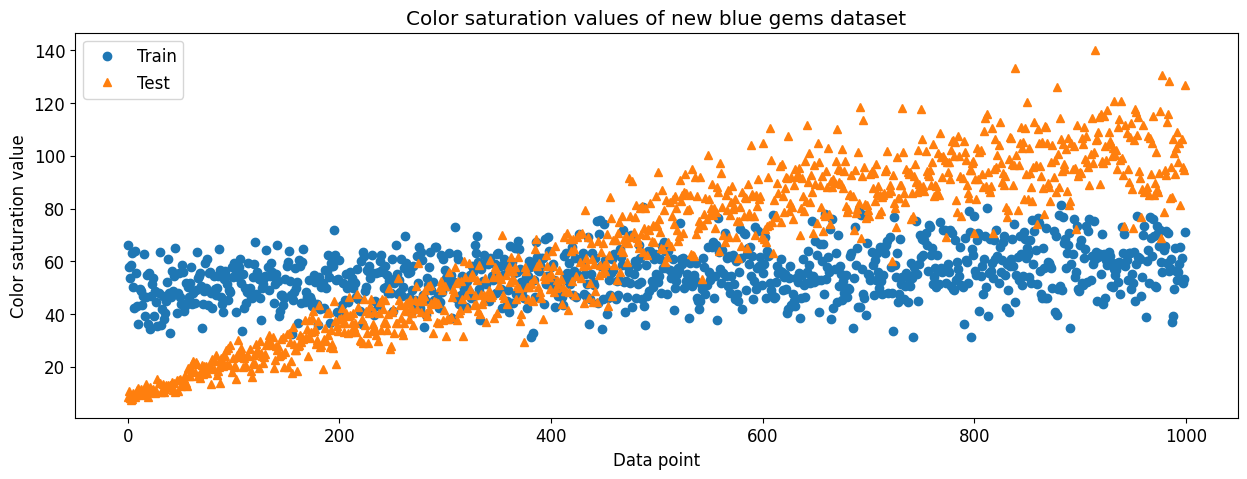

In [19]:
# riginal_sunrgbd_path = r"..\datasets\SUNRGBD\RGB_original"

# saturation_values_sunrgbd_original = get_saturation_values(, split='test')

saturation_values_blue_gems_new_train = get_saturation_values(new_saturation_gems_blue_path, split='train')
saturation_values_blue_gems_new_test = get_saturation_values(new_saturation_gems_blue_path, split='test')


plt.figure(figsize=(15, 5))
plt.plot(saturation_values_blue_gems_new_train, 'o', label='Train')
plt.plot(saturation_values_blue_gems_new_test, '^', label='Test')
plt.xlabel("Data point")
plt.ylabel("Color saturation value")
plt.title("Color saturation values of new blue gems dataset")
plt.legend()
plt.show()

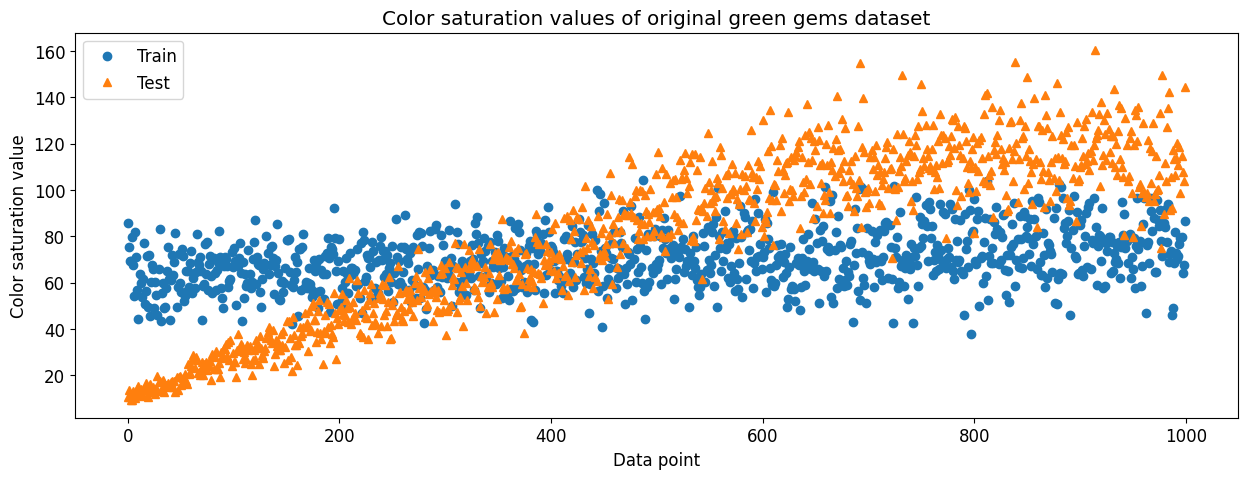

In [20]:
saturation_values_green_gems_original_train = get_saturation_values(original_saturation_gems_green_path, split='train')
saturation_values_green_gems_original_test = get_saturation_values(original_saturation_gems_green_path, split='test')

plt.figure(figsize=(15, 5))
plt.plot(saturation_values_green_gems_original_train, 'o', label='Train')
plt.plot(saturation_values_green_gems_original_test, '^', label='Test')
plt.xlabel("Data point")
plt.ylabel("Color saturation value")
plt.title("Color saturation values of original green gems dataset")
plt.legend()
plt.show()